In [65]:
# DataSet: FMD
# Treino da CNN e Validação do treino: base de dados dividida ao meio aleatória mente
#                                      sendo 50% treino, 50% validação
# A T E N Ç Ã O: Não se esqueça de alterar o nome dos arquivos que vão receber
#                 os dados estatísticos
xbase = 'UMD'

In [66]:
# Montando o google drive contendo o DataSet
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [67]:
# Carregando bibliotecas do python e criando classes importantes para todo o código
import copy
from collections import namedtuple
from __future__ import print_function, division
import matplotlib.pyplot as plt
import multiprocessing as python_multiprocessing 
import numpy as np
import nltk
import os
import os.path
from PIL import Image
import random
import re
import sys
import pickle
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import torch.utils.data as data
from torchsummary import summary
import torch
#import torchvision.transforms as transforms
import torch.utils.data as data
from torch._six import int_classes as _int_classes
import threading
import itertools
import warnings
from torch._six import container_abcs, string_classes, int_classes
import torch.multiprocessing as multiprocessing
from torch._utils import ExceptionWrapper
from torch._six import queue, string_classes
from torch.utils.data._utils import signal_handling
from torch.utils.data._utils import MP_STATUS_CHECK_INTERVAL
from torch.utils.data._utils import ExceptionWrapper
from torch.utils.data._utils import IS_WINDOWS
from torch.utils.data import IterableDataset
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn
from sklearn import svm

plt.ion()   # interactive mode
 
model_urls = {'resnet18':'https://download.pytorch.org/models/resnet18-5c106cde.pth'}
 
def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
 
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=dilation, groups=groups, bias=False, dilation=dilation)
 
class BasicBlock(nn.Module):
  expansion = 1
  __constants__=['downsample']
 
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride
 
  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
      identity = self.downsample(x)
    
    out += identity
    out = self.relu(out)
 
    return out
 
class Bottleneck(nn.Module):
  expansion = 4
  __constants__ = ['downsample']
 
  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
      width = int(planes * (base_width / 64.)) * groups
      self.conv1 = conv1x1(inplanes, width)
      self.bn1 = norm_layer(width)
      self.conv2 = conv3x3(width, width, stride, groups, dilation)
      self.bn2 = norm_layer(width)
      self.conv3 = conv1x1(width, planes * self.expansion)
      self.bn3 = norm_layer(planes * self.expansion)
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample
      self.stride = stride
 
  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    if self.downsample is not None:
      identity = self.downsample(x)
    out += identity
    out = self.relu(out)
 
    return out
 
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, groups=1, width_per_group=64,
               replace_stride_with_dilation=None, norm_layer=None):
    super(ResNet, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer
    self.inplanes = 64
    self.dilation = 1
    if replace_stride_with_dilation is None:
      replace_stride_with_dilation = [False, False, False]
    self.groups = groups
    self.base_width = width_per_group
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      #valor1 = input("digite algo")
      #print(nn.init.constant_(m.weight, 1))
      #valor2 = input("digite algo")
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, Bottleneck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)
  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
      self.dilation *= stride
      stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride), 
          norm_layer(planes * block.expansion),
      )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation, norm_layer))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes, groups=self.groups, 
                          base_width=self.base_width, dilation=self.dilation,
                          norm_layer = norm_layer))
    return nn.Sequential(*layers)
 
  def _forward_impl(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x
 
  def forward(self, x):
    return self._forward_impl(x)
  
  def resnet18(pretrained=False, progress=True, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
      state_dict = load_state_dict_from_url(model_urls['resnet18'],
                                            progress=progress)
      model.load_state_dict(state_dict)
    return model
 
 
 
class VisionDataset(data.Dataset):
    _repr_indent = 4
 
    def __init__(self, root, transforms=None, transform=None, target_transform=None):
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root
 
        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")
 
        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform
 
        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms
 
    def __getitem__(self, index):
        raise NotImplementedError
 
    def __len__(self):
        raise NotImplementedError
 
    def __repr__(self):
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if hasattr(self, "transforms") and self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)
 
    def _format_transform_repr(self, transform, head):
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])
 
    def extra_repr(self):
        return ""
 
 
class StandardTransform(object):
    def __init__(self, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
 
    def __call__(self, input, target):
        if self.transform is not None:
            input = self.transform(input)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return input, target
 
    def _format_transform_repr(self, transform, head):
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])
 
    def __repr__(self):
        body = [self.__class__.__name__]
        if self.transform is not None:
            body += self._format_transform_repr(self.transform,
                                                "Transform: ")
        if self.target_transform is not None:
            body += self._format_transform_repr(self.target_transform,
                                                "Target transform: ")
 
        return '\n'.join(body)
 
def has_file_allowed_extension(filename, extensions):
    return filename.lower().endswith(extensions)
 
def is_image_file(filename):
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)
 
def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None, treino=None, valid=None):
    dir = os.path.expanduser(dir)
    images=[]
    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return has_file_allowed_extension(x, extensions)
    for target in sorted(class_to_idx.keys()):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue
        for root, _, fnames in sorted(os.walk(d, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = (path, class_to_idx[target])
                    images.append(item)
    im_r=[]
    xtimes=len(images)
    im_r=random.sample(images,xtimes)
    xxtimes = int(xtimes/2)
    imagens_treino=im_r[xxtimes:]
    imagens_valid=im_r[:xxtimes]
    if treino:
        f_images = imagens_treino
    if valid:
        f_images = imagens_valid
    return f_images
 
class DatasetFolder(VisionDataset):
    def __init__(self, root, loader, extensions=None, transform=None,
                 target_transform=None, is_valid_file=None, treino=None, valid=None):
        super(DatasetFolder, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        self.treino = treino
        self.valid = valid
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file, self.treino, self.valid)

        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))
 
        self.loader = loader
        self.extensions = extensions
 
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]
 
    def _find_classes(self, dir):
        global xclasses
        if sys.version_info >= (3, 5):
          
            # Faster and available in Python 3.5 and above
            classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        else:
            classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
        classes.sort()
        xclasses = classes
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx
 
    def __getitem__(self, index):
        
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
 
        return sample, target
 
 
    def __len__(self):
        return len(self.samples)
 
IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
 
def pil_loader(path):
    
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
 
 
def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        
        return pil_loader(path)
 
 
def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)
 
 
class ImageFolder(DatasetFolder):
    
    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader, is_valid_file=None, treino=None, valid=None):
        super(ImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file, treino=treino, valid=valid)
        self.imgs = self.samples

In [68]:
# Aqui é definido como as amostras serão tratadas na CNN
# Nesse momento é definido com a amostra a será utilizada como teste
# E as amostras b, c e d serão utilizadas para validação
data_transforms= {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
Acc_it=[]
modelo=[]
X_train=[]
X_val=[]
val=[]
model_train=[]
model_val=[]
val_inputs=[]
val_labels=[]
train_inputs=[]
train_labels=[]

In [69]:
xend_bd = '/content/gdrive/My Drive/Amostras/'+xbase
image_datasets= {'train': ImageFolder(os.path.join(xend_bd),data_transforms['train'],treino=True),
                     'val': ImageFolder(os.path.join(xend_bd),data_transforms['val'],valid=True)}

In [70]:
# esta função treina o modelo de CNN
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    global best_acc, val_labels, val_inputs, train_labels, train_inputs
    best_acc = 0.0
    ntreino=0
    nval=0
    val_labels = {}
    val_inputs = {}
    train_labels = {}
    train_inputs = {}
    xval_labels={}
    xval_inputs={}
    xtrain_labels={}
    xtrain_inputs={}
    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch, num_epochs - 1))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            xi=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        xtrain_labels[str(ntreino)]=labels
                        xtrain_inputs[str(ntreino)]=inputs
                        ntreino = ntreino + 1
                    if phase == 'val':
                        xval_labels[str(nval)]=labels
                        xval_inputs[str(nval)]=inputs
                        nval = nval + 1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if len(xtrain_labels) != 0:
                    train_labels = xtrain_labels
                if len(xtrain_inputs) != 0:
                    train_inputs = xtrain_inputs
                if len(xval_labels) != 0:
                    val_labels = xval_labels
                if len(xval_inputs) != 0:
                    val_inputs = xval_inputs
            if phase == 'val':
                print('Acurácia da CNN : {:4f}'.format(epoch_acc))
                print('-' * 25) 
        ntreino=0
        nval=0
    print('Mélhor acurácia da CNN: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [71]:
# Gerando o primeiro modelo de CNN: model_ft
dataloaders= {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,shuffle=True, num_workers=4), 
              'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,shuffle=True, num_workers=4)}
dataset_sizes = {'train': len(image_datasets['train']), 'val':len(image_datasets['val'])}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = ResNet.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)


Época 0/24
Acurácia da CNN : 0.860000
-------------------------
Época 1/24
Acurácia da CNN : 0.966000
-------------------------
Época 2/24
Acurácia da CNN : 0.974000
-------------------------
Época 3/24
Acurácia da CNN : 0.984000
-------------------------
Época 4/24
Acurácia da CNN : 0.978000
-------------------------
Época 5/24
Acurácia da CNN : 0.970000
-------------------------
Época 6/24
Acurácia da CNN : 1.000000
-------------------------
Época 7/24
Acurácia da CNN : 0.996000
-------------------------
Época 8/24
Acurácia da CNN : 0.998000
-------------------------
Época 9/24
Acurácia da CNN : 0.996000
-------------------------
Época 10/24
Acurácia da CNN : 0.996000
-------------------------
Época 11/24
Acurácia da CNN : 0.998000
-------------------------
Época 12/24
Acurácia da CNN : 0.998000
-------------------------
Época 13/24
Acurácia da CNN : 0.988000
-------------------------
Época 14/24
Acurácia da CNN : 0.998000
-------------------------
Época 15/24
Acurácia da CNN : 0.998

In [72]:
# retirando a última camada da CNN 
model2=torch.nn.Sequential(*list(model_ft.children())[:-1])


In [73]:
# Obtendo os vetores de recursos
# xxt : armazena as entradas para o treino do próximo classificador
xvezes = len(train_inputs)
xt = np.zeros(((xvezes * 4),512), dtype=np.float64)
x=0
rrr = len(xt)-1
for p in range(rrr):
    xt[p][0] = xt[p][0]-1
for i in range(xvezes):
    vetor = model2(train_inputs[str(i)])
    xvetor = vetor.cpu().detach().numpy()
    xv=list(xvetor.shape)
    ny = (xv[0])-1
    for y in range(ny):
        for j in range(512):
            xt[x][j]=xvetor[y][j]
        x = x+1
hp = len(xt)
for i in range(hp):
    a = xt[i][0]
    b = np.float64(-1)
    if a == b:
      xhp = i
      break
xxt = np.zeros((xhp,512), dtype=np.float64)
for w in range(xhp):
    for q in range(512):
        xxt[w][q] = xt[w][q]

# xxvd : armazena as entradas para a validação do próximo classificador
xvezes = len(val_inputs)
xvd = np.zeros(((xvezes * 4),512), dtype=np.float64)
x=0
rrr = len(xvd)-1
for p in range(rrr):
    xvd[p][0] = xvd[p][0]-1
for i in range(xvezes):
    vetor = model2(val_inputs[str(i)])
    xvetor = vetor.cpu().detach().numpy()
    xv=list(xvetor.shape)
    ny = (xv[0])-1
    for y in range(ny):
        for j in range(512):
            xvd[x][j]=xvetor[y][j]
        x = x+1
hp = len(xvd)
for i in range(hp):
    a = xvd[i][0]
    b = np.float64(-1)
    if a == b:
      yhp = i
      break
xxvd = np.zeros((yhp,512), dtype=np.float64)
for w in range(yhp):
    for q in range(512):
        xxvd[w][q] = xvd[w][q]

# xxlv: armazena as etiquetas para o treino do próximo classificador
xvezes = len(val_labels)
xlv = np.zeros((xvezes * 4), dtype=np.float64)
rrr = len(xlv)-1
for x in range(rrr):
    xlv[x] = xlv[x]-1
x=0
for i in range(xvezes):
    xvetor = val_labels[str(i)].cpu().detach().numpy()
    yv=list(xvetor.shape)
    ny = (yv[0])-1
    for y in range(ny):
        xlv[x]=xvetor[y]
        x = x+1
hp = len(xlv)
for i in range(hp):
    a = xlv[i]
    b = np.float64(-1)
    if a == b:
      xhp = i
      break
xxlv = np.zeros(xhp, dtype=np.float64)
for w in range(xhp):
    xxlv[w] = xlv[w]

# xxlt : armazena as etiquetas para a validação do próximo classificador
xvezes = len(train_labels)
xlt = np.zeros((xvezes * 4), dtype=np.float64)
rrr = len(xlt)-1
for x in range(rrr):
    xlt[x] = xlt[x]-1
x=0
for i in range(xvezes):
    xvetor = train_labels[str(i)].cpu().detach().numpy()
    yv=list(xvetor.shape)
    ny = (yv[0])-1
    for y in range(ny):
        xlt[x]=xvetor[y]
        x = x+1
hp = len(xlt)
for i in range(hp):
    a = xlt[i]
    b = np.float64(-1)
    if a == b:
      yhp = i
      break
xxlt = np.zeros(yhp, dtype=np.float64)
for w in range(yhp):
    xxlt[w] = xlt[w]

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

names = ["KNN", "SVC Linear", "Processo Gaussiano",
         "Árvores de Decisão", "Floresta Aleatória", "MLP", "AdaBoost",
         "Naive Bayes", "Regressão Logística", "Regressão Linear"]

classifiers = [
    KNeighborsClassifier(n_neighbors=5),
    SVC(kernel="linear", C=0.025),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(random_state=1, max_iter=1500),
    LinearRegression()]
i = 1

In [75]:
print("----------------------------------------------------------------------------------")
print("Classificadores utilizando os vetores de recursos tratados no melhor modelo da CNN")
print("**********************************************************************************")
xscores = []
# w_classif será utilizada nas matrizes de confusão, assim como names
w_classif=[]
for name, clf in zip(names, classifiers):
        clf.fit(xxt, xxlt)
        w_classif.append(clf)
        score = clf.score(xxvd, xxlv)
        if i > 1:
            print("*************************************************")
        print(" Classificador "+str(i)+" : "+name)
        print(" Acurácia: "+str(score))
        print()
        xscores.append(score)
        i += 1

----------------------------------------------------------------------------------
Classificadores utilizando os vetores de recursos tratados no melhor modelo da CNN
**********************************************************************************
 Classificador 1 : KNN
 Acurácia: 0.9866666666666667

*************************************************
 Classificador 2 : SVC Linear
 Acurácia: 0.9946666666666667

*************************************************
 Classificador 3 : Processo Gaussiano
 Acurácia: 0.05333333333333334

*************************************************
 Classificador 4 : Árvores de Decisão
 Acurácia: 0.256

*************************************************
 Classificador 5 : Floresta Aleatória
 Acurácia: 0.8826666666666667

*************************************************
 Classificador 6 : MLP
 Acurácia: 0.9946666666666667

*************************************************
 Classificador 7 : AdaBoost
 Acurácia: 0.18133333333333335

***************************

In [76]:
# ****************************************
# A função rank_class rankeia os classificadores conforme suas acurácias
from pprint import pprint
def rank_class(xtotal, xnomes, xscor):
    # xtotal : (inteiro) informa a quantidade de classificadores que serão rankeados
    # xnomes : (lista) nomes dos classificadores
    # xscor : (lista) valores dos scores de cada classificador
    xdic_class_0 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_1 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_2 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_3 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_4 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_5 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_6 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_7 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_8 = {'xclass' : 'classe', 'yscor' : -100.00}
    xdic_class_9 = {'xclass' : 'classe', 'yscor' : -100.00}
    xconta = 0
    for q in range(xtotal):
        if q == 0:
          xdic_class_0 = {'xclass' : xnomes[0], 'yscor' : xscor[0]}
        if q == 1:
          xdic_class_1 = {'xclass' : xnomes[1], 'yscor' : xscor[1]}
        if q == 2:
          xdic_class_2 = {'xclass' : xnomes[2], 'yscor' : xscor[2]}
        if q == 3:
          xdic_class_3 = {'xclass' : xnomes[3], 'yscor' : xscor[3]}
        if q == 4:
          xdic_class_4 = {'xclass' : xnomes[4], 'yscor' : xscor[4]}
        if q == 5:
          xdic_class_5 = {'xclass' : xnomes[5], 'yscor' : xscor[5]}
        if q == 6:
          xdic_class_6 = {'xclass' : xnomes[6], 'yscor' : xscor[6]}
        if q == 7:
          xdic_class_7 = {'xclass' : xnomes[7], 'yscor' : xscor[7]}
        if q == 8:
          xdic_class_8 = {'xclass' : xnomes[8], 'yscor' : xscor[8]}
        if q == 9:
          xdic_class_9 = {'xclass' : xnomes[9], 'yscor' : xscor[9]}
    xdic_class = [xdic_class_0, 
                  xdic_class_1, 
                  xdic_class_2, 
                  xdic_class_3,
                  xdic_class_4,
                  xdic_class_5,
                  xdic_class_6,
                  xdic_class_7,
                  xdic_class_8,
                  xdic_class_9]
    print('Sem ordem')
    pprint(xdic_class)
    print('Com ordem')
    xdic_ordenado = sorted(xdic_class, key=lambda k: k['yscor']) 
    pprint(xdic_ordenado)
    xscor_class = []
    xnome_class = []
    xxvezes = 9
    for i in range(10):
      xdic=xdic_ordenado[xxvezes]
      xscor_class.append(xdic['yscor'])
      xnome_class.append(xdic['xclass'])
      xxvezes -= 1
    p_scor = xscor_class[0]
    s_scor = t_scor = 0
    n_prim = 0
    n_seg = 0
    n_ter = 0
    ppp = 0
    qqq = 0
    zzz = 0
    xscor_final = []
    xnome_final =[]
    for a in range(10):
      if xscor_class[a] != -100.00:
        if xscor_class[a] >= p_scor:
            xscor_final.append(p_scor)
            xnome_final.append(xnome_class[a])
            n_prim += 1          
        else:
            ppp += 1
            if ppp == 1:
              s_scor = xscor_class[a]
            if xscor_class[a] >= s_scor:
              xscor_final.append(s_scor)
              xnome_final.append(xnome_class[a])
              n_seg += 1
            else:
              qqq += 1
              if qqq == 1:
                t_scor = xscor_class[a]
              if xscor_class[a] >= t_scor:
                xscor_final.append(t_scor)
                xnome_final.append(xnome_class[a])
                n_ter += 1
    return xscor_final,xnome_final,n_prim,n_seg,n_ter

In [77]:
xnomes = ['KNN', 'SVC', 'Processo Gaussiano', 'Árvores de Decisão', 'Floresta Aleatória', 
          'MLP', 'AdaBoost', 'Naive Bayes', 'Regressão Logística', 'Regressão Linear']
xval, xpp, n_prim, n_seg, n_ter = rank_class(10, xnomes, xscores)
xroda = n_prim+n_seg+n_ter
xyn_prim = n_prim
xyn_seg = n_seg
xyn_ter = n_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores utilizando os vetores de recursos")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xyn_prim != 0:
    if xyn_prim == n_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(xval[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+xpp[q])
      xyn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+xpp[q])
      xyn_prim -= 1
  else:
    if xyn_seg != 0:
      if xyn_seg == n_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(xval[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+xpp[q])
        xyn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+xpp[q])
        xyn_seg -= 1
    else:
      if xyn_ter != 0:
        if xyn_ter == n_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(xval[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+xpp[q])
          xyn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+xpp[q])
          xyn_ter -= 1

Sem ordem
[{'xclass': 'KNN', 'yscor': 0.9866666666666667},
 {'xclass': 'SVC', 'yscor': 0.9946666666666667},
 {'xclass': 'Processo Gaussiano', 'yscor': 0.05333333333333334},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.256},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.8826666666666667},
 {'xclass': 'MLP', 'yscor': 0.9946666666666667},
 {'xclass': 'AdaBoost', 'yscor': 0.18133333333333335},
 {'xclass': 'Naive Bayes', 'yscor': 0.9493333333333334},
 {'xclass': 'Regressão Logística', 'yscor': 0.992},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371}]
Com ordem
[{'xclass': 'Processo Gaussiano', 'yscor': 0.05333333333333334},
 {'xclass': 'AdaBoost', 'yscor': 0.18133333333333335},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.256},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.8826666666666667},
 {'xclass': 'Naive Bayes', 'yscor': 0.9493333333333334},
 {'xclass': 'KNN', 'yscor': 0.9866666666666667},
 {'xclass': 'Regressão L

In [78]:
# Ajustando os classificadores usando GridSearchCV
##################################################

# Regressão Logística
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Criando um novo modelo LogR
LogR = LogisticRegression()
# Criando um dicionário com as variações do parâmetro normalize
params_LogR = {'random_state': [1, 2, 3, 4, 5],
               'max_iter': [1000, 1500, 2000, 2500, 3000]}

#  Quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
LogR_gs = GridSearchCV(LogR, params_LogR, cv=5)

# Treinando o modelo
LogR_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
LogR_best = LogR_gs.best_estimator_

# LogR_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
LogR_scor = LogR_best.score(xxvd, xxlv)

# xxt_LogR e xxv_LogR serão utilizados como recursos para o empilhamento total
xxtreino_LogR = LogR_best.predict(xxt)
xxt_LogR = pd.DataFrame(xxtreino_LogR)
xxvalid_LogR = LogR_best.predict(xxvd)
xxv_LogR = pd.DataFrame(xxvalid_LogR)


# K-NN (K vizinhos mais próximos)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Criando um novo modelo KNN
knn = KNeighborsClassifier()

# Criando um dicionário com as variações do parâmetro n_neighbors (número de vizinhos) a ser testado
params_knn = {'n_neighbors': np.arange(1, 25)}

# Usando GridSearchCV para testar todos os valores de vizinhos (neighbors),
#  quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
knn_gs = GridSearchCV(knn, params_knn, cv=5)

# Treinando o modelo
knn_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
knn_best = knn_gs.best_estimator_

# knn_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
knn_scor = knn_best.score(xxvd, xxlv)

# xxt_knn e xxv_knn serão utilizados 
# como recursos para o empilhamento total
xxtreino_knn = knn_best.predict(xxt)
xxt_knn = pd.DataFrame(xxtreino_knn)
xxvalid_knn = knn_best.predict(xxvd)
xxv_knn = pd.DataFrame(xxvalid_knn)

# Floresta Aleatória (Random Forest)
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Criando um novo classificador do tipo Floresta Aleatória
rf = RandomForestClassifier(max_depth=5, max_features=1)

# O hiperparâmetro n_estimators indica o número de árvores construídas pelo algoritmo antes de realizar
#   uma votação ou fazer uma média de predições.
# Abaixo criamos um dicionário com valores que queremos testar para n_estimators
params_rf = {'n_estimators': [25, 50, 75, 100, 125, 150]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)

# Treinando o modelo
rf_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
rf_best = rf_gs.best_estimator_

# rf_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
rf_scor = rf_best.score(xxvd, xxlv)

# xxt_rf e xxv_rf serão utilizados 
# como recursos para o empilhamento total
xxtreino_rf = rf_best.predict(xxt)
xxt_rf = pd.DataFrame(xxtreino_rf)
xxvalid_rf = rf_best.predict(xxvd)
xxv_rf = pd.DataFrame(xxvalid_rf)

# MLP: MultiLayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do MLP
mlp = MLPClassifier()

# Alfa é um parâmetro para o termo de regularização, também conhecido como termo de penalidade,
#    que combate o overfitting ao restringir o tamanho dos pesos.
# Abaixo criamos um dicionário com valores que queremos testar para alpha
params_mlp = {'alpha': [0.1, 0.2, 0.3, 0.4],
               'max_iter': [1000, 1500, 2000, 2500]}

# Usando o GridSearchCV 
mlp_gs = GridSearchCV(mlp, params_mlp, cv=5)

# Treinando o modelo
mlp_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
mlp_best = mlp_gs.best_estimator_

# mlp_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
mlp_scor = mlp_best.score(xxvd, xxlv)

# xxt_mlp e xxv_mlp serão utilizados 
# como recursos para o empilhamento total
xxtreino_mlp = mlp_best.predict(xxt)
xxt_mlp = pd.DataFrame(xxtreino_mlp)
xxvalid_mlp = mlp_best.predict(xxvd)
xxv_mlp = pd.DataFrame(xxvalid_mlp)

# AB: AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do MLP
cl_ada = AdaBoostClassifier()

# n_estimators int, padrão = 50
# O número máximo de estimadores nos quais o aumento é finalizado. 
# Em caso de ajuste perfeito, o procedimento de aprendizado é interrompido mais cedo.
params_ada = {'n_estimators': [30, 35, 40, 45, 50, 55, 65, 70]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
ada_gs = GridSearchCV(cl_ada, params_ada, cv=5)

# Treinando o modelo
ada_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
ada_best = ada_gs.best_estimator_

# ada_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
ada_scor = ada_best.score(xxvd, xxlv)

# xxt_ada e xxv_ada serão utilizados 
# como recursos para o empilhamento total
xxtreino_ada = ada_best.predict(xxt)
xxt_ada = pd.DataFrame(xxtreino_ada)
xxvalid_ada = ada_best.predict(xxvd)
xxv_ada = pd.DataFrame(xxvalid_ada)


# GNB: GaussianNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador
gnb = GaussianNB()

# Praticamente não há parâmetros para variar
params_gnb = {'priors': [None]}

# Usando o GridSearchCV 
gnb_gs = GridSearchCV(gnb, params_gnb, cv=5)

# Treinando o modelo
gnb_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
gnb_best = gnb_gs.best_estimator_

# gnb_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
gnb_scor = gnb_best.score(xxvd, xxlv)

# xxt_ada e xxv_ada serão utilizados 
# como recursos para o empilhamento total
xxtreino_gnb = gnb_best.predict(xxt)
xxt_gnb = pd.DataFrame(xxtreino_gnb)
xxvalid_gnb = gnb_best.predict(xxvd)
xxv_gnb = pd.DataFrame(xxvalid_gnb)


# Classificador com vetores de suporte (SVC)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC

cl_svc = SVC()

# Vamos variar dois parâmetros dessa vez, o kernel e o parâmetro de regularização C

params_svc = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], 'kernel':['linear', 'sigmoid']}

# Usando o GridSearchCV para testar todos os valores dos parâmetros

svc_gs = GridSearchCV(cl_svc, params_svc, cv=5)

# Treinando o modelo

svc_gs.fit(xxt, xxlt)

# Salvando o melhor modelo

svc_best = svc_gs.best_estimator_

# svc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
svc_scor = svc_best.score(xxvd, xxlv)

# xxt_ada e xxv_ada serão utilizados 
# como recursos para o empilhamento total
xxtreino_svc = svc_best.predict(xxt)
xxt_svc = pd.DataFrame(xxtreino_svc)
xxvalid_svc = svc_best.predict(xxvd)
xxv_svc = pd.DataFrame(xxvalid_svc)


# Classificação de processo Gaussiana (GPC) com base na aproximação de Laplace.
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import pandas as pd

# RBF: Kernel de função de base radial (também conhecido como kernel quadrado-exponencial).
# Seu parâmetro length_scale é padronizado para 1.0
kernel1 = 0.90 * RBF (1.0)
kernel2 = 0.95 * RBF (1.0)
kernel3 = 1.0 * RBF (1.0)

# Criando um classificador GPC
cl_gpc = GaussianProcessClassifier()

# Vamos variar o kernel desse classificador, veja a biblioteca
# https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html
# para maiores detalhes desse parâmetro
params_gpc = {'kernel':[kernel1, kernel2, kernel3]}
                        
# Usando o GridSearchCV para testar todos os valores dos parâmetros
gpc_gs = GridSearchCV(cl_gpc, params_gpc, cv=5)

# Treinando o modelo
gpc_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
gpc_best = gpc_gs.best_estimator_

# gpc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
gpc_scor = gpc_best.score(xxvd, xxlv)

# xxt_gpc e xxv_gpc serão utilizados 
# como recursos para o empilhamento total
xxtreino_gpc = gpc_best.predict(xxt)
xxt_gpc = pd.DataFrame(xxtreino_gpc)
xxvalid_gpc = gpc_best.predict(xxvd)
xxv_gpc = pd.DataFrame(xxvalid_gpc)

# Classificador com arvores de decisão (DTC)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
cl_dtc = DecisionTreeClassifier()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
params_dtc = {'max_depth':[3, 5, 7, 9, 11, 13, 15]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
dtc_gs = GridSearchCV(cl_dtc, params_dtc, cv=5)

# Treinando o modelo
dtc_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
dtc_best = dtc_gs.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
dtc_scor = dtc_best.score(xxvd, xxlv)

# xxt_dtc e xxv_dtc serão utilizados 
# como recursos para o empilhamento total
xxtreino_dtc = dtc_best.predict(xxt)
xxt_dtc = pd.DataFrame(xxtreino_dtc)
xxvalid_dtc = dtc_best.predict(xxvd)
xxv_dtc = pd.DataFrame(xxvalid_dtc)


# Classificador por regressão linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
cl_LR = LinearRegression()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
params_LR = {'normalize':[True, False]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
LR_gs = GridSearchCV(cl_LR, params_LR, cv=5)

# Treinando o modelo
LR_gs.fit(xxt, xxlt)

# Salvando o melhor modelo
LR_best = LR_gs.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
LR_scor = LR_best.score(xxvd, xxlv)

# xxt_LR e xxv_LR serão utilizados 
# como recursos para o empilhamento total
xxtreino_LR = LR_best.predict(xxt)
xxt_LR = pd.DataFrame(xxtreino_LR)
xxvalid_LR = LR_best.predict(xxvd)
xxv_LR = pd.DataFrame(xxvalid_LR)

# Scores dos classificadores com parâmetros ajustados
print()
print("*********************************************************************************")
print("Acurácia das árvores de decisão com parâmetro ajustado: " +str(dtc_scor)) #1
print("Parâmetro ajustado: "+str(dtc_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do Processo Gaussiano com parâmetro ajustado: " +str(gpc_scor)) #2
print("Parâmetro ajustado: "+str(gpc_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do SVC com parâmetros ajustados: " +str(svc_scor)) #3
print("Parâmetros ajustados: "+str(svc_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do Naive Bayes: " +str(gnb_scor))
print(" Para esse classificador não ajustamos parâmetros.") #4
print()
print("*********************************************************************************")
print("Acurácia do AdaBoost com parâmetro ajustado: " +str(ada_scor)) #5
print("Parâmetro ajustado: "+str(ada_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do MLP com parâmetros ajustados: " +str(mlp_scor)) #6
print("Parâmetros ajustados: "+str(mlp_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da Floresta Aleatória com parâmetro ajustado: " +str(rf_scor)) #7
print("Parâmetro ajustado: "+str(rf_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do KNN com parâmetro ajustado: " +str(knn_scor)) #8
print("Parâmetro ajustado: "+str(knn_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da Regressão Logísica com parâmetros ajustados: " +str(LogR_scor)) #9
print("Parâmetros ajustados: "+str(LogR_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da regressão linear com parâmetro ajustado: " +str(LR_scor)) #10
print("Parâmetro ajustado: "+str(LR_gs.best_params_))


*********************************************************************************
Acurácia das árvores de decisão com parâmetro ajustado: 0.6346666666666667
Parâmetro ajustado: {'max_depth': 15}

*********************************************************************************
Acurácia do Processo Gaussiano com parâmetro ajustado: 0.05333333333333334
Parâmetro ajustado: {'kernel': 0.949**2 * RBF(length_scale=1)}

*********************************************************************************
Acurácia do SVC com parâmetros ajustados: 0.9946666666666667
Parâmetros ajustados: {'C': 1, 'kernel': 'sigmoid'}

*********************************************************************************
Acurácia do Naive Bayes: 0.9493333333333334
 Para esse classificador não ajustamos parâmetros.

*********************************************************************************
Acurácia do AdaBoost com parâmetro ajustado: 0.176
Parâmetro ajustado: {'n_estimators': 35}

*********************************

In [79]:
xnomes = ['KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 'Naive Bayes', 
          'SVC', 'Processo Gaussiano', 'Árvores de Decisão', 'Regressão Logística', 'Regressão Linear']
xscor = [knn_scor, rf_scor, mlp_scor, ada_scor, gnb_scor, svc_scor, gpc_scor, dtc_scor, LogR_scor, LR_scor]
xscor1, xprim, xn_prim, xn_seg, xn_ter = rank_class(10, xnomes, xscor)
xroda = n_prim+n_seg+n_ter
xxn_prim = xn_prim
xxn_seg = xn_seg
xxn_ter = xn_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores, utilizando Vetores de Recurso e com parâmetros ajustados")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xxn_prim != 0:
    if xxn_prim == xn_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(xscor1[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+xprim[q])
      xxn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+xprim[q])
      xxn_prim -= 1
  else:
    if xxn_seg != 0:
      if xxn_seg == xn_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(xscor1[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+xprim[q])
        xxn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+xprim[q])
        xxn_seg -= 1
    else:
      if xxn_ter != 0:
        if xxn_ter == xn_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(xscor1[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+xprim[q])
          xxn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+xprim[q])
          xxn_ter -= 1

Sem ordem
[{'xclass': 'KNN', 'yscor': 0.9893333333333333},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.984},
 {'xclass': 'MLP', 'yscor': 0.9866666666666667},
 {'xclass': 'AdaBoost', 'yscor': 0.176},
 {'xclass': 'Naive Bayes', 'yscor': 0.9493333333333334},
 {'xclass': 'SVC', 'yscor': 0.9946666666666667},
 {'xclass': 'Processo Gaussiano', 'yscor': 0.05333333333333334},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.6346666666666667},
 {'xclass': 'Regressão Logística', 'yscor': 0.992},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371}]
Com ordem
[{'xclass': 'Processo Gaussiano', 'yscor': 0.05333333333333334},
 {'xclass': 'AdaBoost', 'yscor': 0.176},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.6346666666666667},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371},
 {'xclass': 'Naive Bayes', 'yscor': 0.9493333333333334},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.984},
 {'xclass': 'MLP', 'yscor': 0.9866666666666667},
 {'xclass': 'KNN', 'yscor': 0.9893333333333333},
 {'

In [80]:
# Realizando a votação das classificações
from sklearn.ensemble import VotingClassifier

# Criando um dicionário com nossos modelos
# observação: VotingClassifier não aceita regressão lienar como classificador

estimators = [('knn', knn_best), 
              ('rf', rf_best), 
              ('mlp', mlp_best), 
              ('ada', ada_best), 
              ('gnb', gnb_best), 
              ('svc', svc_best), 
              ('gpc', gpc_best), 
              ('dtc', dtc_best),
              ('LogR', LogR_best)]

# Criando a classificação por votação

ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(xxt, xxlt)
xensemb = ensemble.score(xxvd, xxlv)

# Exibindo a acurácia que obteve maior número de votos
print("Acurácia da votação entre classificadores: "+str(xensemb))

Acurácia da votação entre classificadores: 0.9973333333333333


In [81]:
# Empilhamento TOTAL
import pandas as pd
xx_treino = pd.concat([xxt_knn, 
                       xxt_rf,
                       xxt_mlp, 
                       xxt_ada, 
                       xxt_gnb, 
                       xxt_svc, 
                       xxt_gpc, 
                       xxt_dtc,
                       xxt_LogR,
                       xxt_LR], axis = 1)

xx_valid = pd.concat([xxv_knn, 
                      xxv_rf, 
                      xxv_mlp, 
                      xxv_ada, 
                      xxv_gnb, 
                      xxv_svc, 
                      xxv_gpc, 
                      xxv_dtc,
                      xxv_LogR,
                      xxv_LR], axis = 1)

In [82]:
# Classificação com empilhamento total 
# Usando GridSearchCV para ajustar os classificadores
######################################################

# Regressão Logística
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Criando um novo modelo LogR
LogR2 = LogisticRegression()
# Criando um dicionário com as variações do parâmetro normalize
params_LogR2 = {'random_state': [1, 2, 3, 4, 5],
               'max_iter': [1000, 1500, 2000, 2500, 3000]}

#  Quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
LogR_gs2 = GridSearchCV(LogR2, params_LogR2, cv=5)

# Treinando o modelo
LogR_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
LogR_best2 = LogR_gs2.best_estimator_

# LogR_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
LogR_scor2 = LogR_best2.score(xx_valid, xxlv)

# K-NN (K vizinhos mais próximos)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Criando um novo modelo KNN
knn2 = KNeighborsClassifier()

# Criando um dicionário com as variações do parâmetro n_neighbors (número de vizinhos) a ser testado
params_knn2 = {'n_neighbors': np.arange(1, 25)}

# Usando GridSearchCV para testar todos os valores de vizinhos (neighbors),
#  quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
knn_gs2 = GridSearchCV(knn2, params_knn2, cv=5)

# Treinando o modelo
knn_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
knn_best2 = knn_gs2.best_estimator_

# knn_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
knn_scor2 = knn_best2.score(xx_valid, xxlv)

# Floresta Aleatória (Random Forest)
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Criando um novo classificador do tipo Floresta Aleatória
rf2 = RandomForestClassifier(max_depth=5, max_features=1)

# O hiperparâmetro n_estimators indica o número de árvores construídas pelo algoritmo antes de realizar
#   uma votação ou fazer uma média de predições.
# Abaixo criamos um dicionário com valores que queremos testar para n_estimators
params_rf2 = {'n_estimators': [25, 50, 75, 100, 125, 150]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
rf_gs2 = GridSearchCV(rf2, params_rf2, cv=5)

# Treinando o modelo
rf_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
rf_best2 = rf_gs2.best_estimator_

# rf_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
rf_scor2 = rf_best2.score(xx_valid, xxlv)


# MLP: MultiLayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do MLP
mlp2 = MLPClassifier()

# Alfa é um parâmetro para o termo de regularização, também conhecido como termo de penalidade,
#    que combate o overfitting ao restringir o tamanho dos pesos.
# Abaixo criamos um dicionário com valores que queremos testar para alpha
params_mlp2 = {'alpha': [0.1, 0.2, 0.3, 0.4],
               'max_iter': [1000, 1500, 2000, 2500]}

# Usando o GridSearchCV 
mlp_gs2 = GridSearchCV(mlp2, params_mlp2, cv=5)

# Treinando o modelo
mlp_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
mlp_best2 = mlp_gs2.best_estimator_

# mlp_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
mlp_scor2 = mlp_best2.score(xx_valid, xxlv)

# AB: AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do ADA
cl_ada2 = AdaBoostClassifier()

# n_estimators int, padrão = 50
# O número máximo de estimadores nos quais o aumento é finalizado. 
# Em caso de ajuste perfeito, o procedimento de aprendizado é interrompido mais cedo.
params_ada2 = {'n_estimators': [30, 35, 40, 45, 50, 55, 65, 70]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
ada_gs2 = GridSearchCV(cl_ada2, params_ada2, cv=5)

# Treinando o modelo
ada_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
ada_best2 = ada_gs2.best_estimator_

# ada_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
ada_scor2 = ada_best2.score(xx_valid, xxlv)

# GNB: GaussianNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador
gnb2 = GaussianNB()

# Praticamente não há parâmetros para variar
params_gnb2 = {'priors': [None]}

# Usando o GridSearchCV 
gnb_gs2 = GridSearchCV(gnb2, params_gnb2, cv=5)

# Treinando o modelo
gnb_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
gnb_best2 = gnb_gs2.best_estimator_

# ada_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
gnb_scor2 = gnb_best2.score(xx_valid, xxlv)

# Classificador com vetores de suporte (SVC)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC

cl_svc2 = SVC()

# Vamos variar dois parâmetros dessa vez, o kernel e o parâmetro de regularização C

params_svc2 = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], 'kernel':['linear', 'sigmoid']}

# Usando o GridSearchCV para testar todos os valores dos parâmetros

svc_gs2 = GridSearchCV(cl_svc2, params_svc2, cv=5)

# Treinando o modelo

svc_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo

svc_best2 = svc_gs2.best_estimator_

# svc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
svc_scor2 = svc_best2.score(xx_valid, xxlv)

# Classificador com arvores de decisão (DTC)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
cl_dtc2 = DecisionTreeClassifier()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
params_dtc2 = {'max_depth':[3, 5, 7, 9, 11, 13, 15]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
dtc_gs2 = GridSearchCV(cl_dtc2, params_dtc2, cv=5)

# Treinando o modelo
dtc_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
dtc_best2 = dtc_gs2.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
dtc_scor2 = dtc_best2.score(xx_valid, xxlv)

# Classificador por regressão linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
cl_LR2 = LinearRegression()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
params_LR2 = {'normalize':[True, False]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
LR_gs2 = GridSearchCV(cl_LR2, params_LR2, cv=5)

# Treinando o modelo
LR_gs2.fit(xx_treino, xxlt)

# Salvando o melhor modelo
LR_best2 = LR_gs2.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
LR_scor2 = LR_best2.score(xx_valid, xxlv)

# Scores com os classificadores ajustados
print()
print("*********************************************************************************")
print("Acurácia das árvores de decisão com parâmetro ajustado: " +str(dtc_scor2))
print("Parâmetro ajustado: "+str(dtc_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do SVC com parâmetros ajustados: " +str(svc_scor2))
print("Parâmetros ajustados: "+str(svc_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do Naive Bayes: " +str(gnb_scor2))
print(" Para esse classificador não ajustamos parâmetros.")
print()
print("*********************************************************************************")
print("Acurácia do AdaBoost com parâmetro ajustado: " +str(ada_scor2))
print("Parâmetros ajustado: "+str(ada_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do MLP com parâmetro ajustado: " +str(mlp_scor2))
print("Parâmetro ajustado: "+str(mlp_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da Floresta Aleatória com parâmetro ajustado: " +str(rf_scor2))
print("Parâmetro ajustado: "+str(rf_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do KNN com parâmetro ajustado: " +str(knn_scor2))
print("Parâmetro ajustado: "+str(knn_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da Regressão Logísica com parâmetros ajustados: " +str(LogR_scor2))
print("Parâmetros ajustados: "+str(LogR_gs2.best_params_))
print()
print("*********************************************************************************")
print("Acurácia das árvores de decisão com parâmetro ajustado: " +str(LR_scor2))
print("Parâmetro ajustado: "+str(LR_gs2.best_params_))
print()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



*********************************************************************************
Acurácia das árvores de decisão com parâmetro ajustado: 0.5093333333333333
Parâmetro ajustado: {'max_depth': 13}

*********************************************************************************
Acurácia do SVC com parâmetros ajustados: 0.272
Parâmetros ajustados: {'C': 0.1, 'kernel': 'linear'}

*********************************************************************************
Acurácia do Naive Bayes: 0.26666666666666666
 Para esse classificador não ajustamos parâmetros.

*********************************************************************************
Acurácia do AdaBoost com parâmetro ajustado: 0.4186666666666667
Parâmetros ajustado: {'n_estimators': 70}

*********************************************************************************
Acurácia do MLP com parâmetro ajustado: 0.216
Parâmetro ajustado: {'alpha': 0.3, 'max_iter': 1500}

*********************************************************************

In [83]:
xnomes = ['KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 'Naive Bayes', 'SVC',
          'Árvores de Decisão', 'Regressão Logística', 'Regressão Linear']
xscor = [knn_scor2, rf_scor2, mlp_scor2, ada_scor2, gnb_scor2, svc_scor2, dtc_scor2, LogR_scor2, LR_scor]
et_scor, et_prim, et_n_prim, et_n_seg, et_n_ter = rank_class(9, xnomes, xscor)
xroda = et_n_prim+et_n_seg+et_n_ter
xxn_prim = et_n_prim
xxn_seg = et_n_seg
xxn_ter = et_n_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores com empilhamento total")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xxn_prim != 0:
    if xxn_prim == et_n_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(et_scor[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+et_prim[q])
      xxn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+et_prim[q])
      xxn_prim -= 1
  else:
    if xxn_seg != 0:
      if xxn_seg == et_n_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(et_scor[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+et_prim[q])
        xxn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+et_prim[q])
        xxn_seg -= 1
    else:
      if xxn_ter != 0:
        if xxn_ter == et_n_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(et_scor[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+et_prim[q])
          xxn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+et_prim[q])
          xxn_ter -= 1

Sem ordem
[{'xclass': 'KNN', 'yscor': 0.28},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.8293333333333334},
 {'xclass': 'MLP', 'yscor': 0.216},
 {'xclass': 'AdaBoost', 'yscor': 0.4186666666666667},
 {'xclass': 'Naive Bayes', 'yscor': 0.26666666666666666},
 {'xclass': 'SVC', 'yscor': 0.272},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.5093333333333333},
 {'xclass': 'Regressão Logística', 'yscor': 0.37333333333333335},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371},
 {'xclass': 'classe', 'yscor': -100.0}]
Com ordem
[{'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'MLP', 'yscor': 0.216},
 {'xclass': 'Naive Bayes', 'yscor': 0.26666666666666666},
 {'xclass': 'SVC', 'yscor': 0.272},
 {'xclass': 'KNN', 'yscor': 0.28},
 {'xclass': 'Regressão Logística', 'yscor': 0.37333333333333335},
 {'xclass': 'AdaBoost', 'yscor': 0.4186666666666667},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.5093333333333333},
 {'xclass': 'Regressão Linear', 'yscor': 0.7732639256029371},
 {'xclass': 'F

In [84]:
# Classificação com empilhamento seletivo
import pandas as pd
xclassif = ['KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 'Naive Bayes', 'SVC', 
            'Árvores de Decisão', 'Regressão Logística', 'Regressão Linear']
clf2 = [knn_best2,
        rf_best2,
        mlp_best2,
        ada_best2,
        svc_best2,
        gnb_best2,
        dtc_best2,
        LogR_best2,
        LR_best2]
xt_classif =[xxt_knn,
             xxt_rf,
             xxt_mlp,
             xxt_ada,
             xxt_svc,
             xxt_gnb,
             xxt_dtc,
             xxt_LogR,
             xxt_LR]
xv_classif =[xxv_knn,
             xxv_rf,
             xxv_mlp,
             xxv_ada,
             xxv_svc,
             xxv_gnb,
             xxv_dtc,
             xxv_LogR,
             xxv_LR]
classif = []
x=0
clf3 = []
yhj = 0
n_class_et = et_n_prim+et_n_seg+et_n_ter
for x in range(n_class_et):
  for y in range(9):
    if et_prim[x] == xclassif[y]:
        classif.append(xclassif[y])
        clf3.append(clf2[y])
        yhj += 1
ptreino = []
pval = []
xv1 = 0
xn_class = xn_prim+xn_seg+xn_ter
for x in range(xn_class):
  for y in range(9):
    if xprim[x] == xclassif[y]:
        xv1 += 1
        ptreino.append(xt_classif[y])
        pval.append(xv_classif[y])
es_treino = []
es_valid = []
for k in range(xv1):
  es_treino.append(ptreino[k])
  es_valid.append(pval[k])
xx_treino = pd.concat(es_treino, axis = 1)
xx_valid = pd.concat(es_valid, axis = 1)
i = 0
xs_scores = []
for name, clf in zip(classif, clf3):
        clf.fit(xx_treino, xxlt)
        score = clf.score(xx_valid, xxlv)
        xs_scores.append(score)
        i += 1
es_scor, es_prim, es_n_prim, es_n_seg, es_n_ter = rank_class(i, xnomes, xs_scores)
xroda = es_n_prim+es_n_seg+es_n_ter
xxn_prim = es_n_prim
xxn_seg = es_n_seg
xxn_ter = es_n_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores com empilhamento seletivo")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xxn_prim != 0:
    if xxn_prim == es_n_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(es_scor[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+es_prim[q])
      xxn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+es_prim[q])
      xxn_prim -= 1
  else:
    if xxn_seg != 0:
      if xxn_seg == es_n_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(es_scor[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+es_prim[q])
        xxn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+es_prim[q])
        xxn_seg -= 1
    else:
      if xxn_ter != 0:
        if xxn_ter == es_n_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(es_scor[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+es_prim[q])
          xxn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+es_prim[q])
          xxn_ter -= 1

Sem ordem
[{'xclass': 'KNN', 'yscor': 0.896},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.9881055093386472},
 {'xclass': 'MLP', 'yscor': 0.9813333333333333},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0}]
Com ordem
[{'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'KNN', 'yscor': 0.896},
 {'xclass': 'MLP', 'yscor': 0.9813333333333333},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.9881055093386472}]
------------------------------------------------------------------------
*************************************************

In [85]:
# Mistura total
import pandas as pd
m_xxt = pd.DataFrame(xxt)
m_xxvd = pd.DataFrame(xxvd)
xm_treino = pd.concat([xx_treino, 
                       m_xxt], axis = 1)

xm_valid = pd.concat([xx_valid, 
                      m_xxvd], axis = 1)

In [86]:
# Classificação com mistura total 
# Usando GridSearchCV para ajustar os classificadores
######################################################

# Regressão Logística
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Criando um novo modelo LogR
m_LogR = LogisticRegression()
# Criando um dicionário com as variações dos parâmetros a serem testados
m_params_LogR = {'random_state': [1, 2, 3, 4, 5],
               'max_iter': [1000, 1500, 2000, 2500, 3000]}

#  Quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
m_LogR_gs = GridSearchCV(m_LogR, m_params_LogR, cv=5)

# Treinando o modelo
m_LogR_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_LogR_best = m_LogR_gs.best_estimator_

# LogR_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_LogR_scor = m_LogR_best.score(xm_valid, xxlv)

# K-NN (K vizinhos mais próximos)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Criando um novo modelo KNN
m_knn = KNeighborsClassifier()

# Criando um dicionário com as variações do parâmetro n_neighbors (número de vizinhos) a ser testado
m_params_knn = {'n_neighbors': np.arange(1, 25)}

# Usando GridSearchCV para testar todos os valores de vizinhos (neighbors),
#  quando cv é um número inteiro o GridSearchCV executa um StratifiedKFolds, 
#  isso quer dizer que o dataset foi divido em 5 partes (ou folds) 
#  e cada parte foi usada como test em uma simulação.
m_knn_gs = GridSearchCV(m_knn, m_params_knn, cv=5)

# Treinando o modelo
m_knn_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_knn_best = m_knn_gs.best_estimator_

# knn_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_knn_scor = m_knn_best.score(xm_valid, xxlv)

# Floresta Aleatória (Random Forest)
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Criando um novo classificador do tipo Floresta Aleatória
m_rf = RandomForestClassifier(max_depth=5, max_features=1)

# O hiperparâmetro n_estimators indica o número de árvores construídas pelo algoritmo antes de realizar
#   uma votação ou fazer uma média de predições.
# Abaixo criamos um dicionário com valores que queremos testar para n_estimators
m_params_rf = {'n_estimators': [25, 50, 75, 100, 125, 150]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
m_rf_gs = GridSearchCV(m_rf, m_params_rf, cv=5)

# Treinando o modelo
m_rf_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_rf_best = m_rf_gs.best_estimator_

# rf_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_rf_scor = m_rf_best.score(xm_valid, xxlv)

# MLP: MultiLayer Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do MLP
m_mlp = MLPClassifier()

# Alfa é um parâmetro para o termo de regularização, também conhecido como termo de penalidade,
#    que combate o overfitting ao restringir o tamanho dos pesos.
# Abaixo criamos um dicionário com valores que queremos testar para alpha
m_params_mlp = {'alpha': [0.1, 0.2, 0.3, 0.4],
               'max_iter': [1000, 1500, 2000, 2500]}

# Usando o GridSearchCV 
m_mlp_gs = GridSearchCV(m_mlp, m_params_mlp, cv=5)

# Treinando o modelo
m_mlp_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_mlp_best = m_mlp_gs.best_estimator_

# mlp_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_mlp_scor = m_mlp_best.score(xm_valid, xxlv)

# AB: AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador do ADA
m_cl_ada = AdaBoostClassifier()

# n_estimators int, padrão = 50
# O número máximo de estimadores nos quais o aumento é finalizado. 
# Em caso de ajuste perfeito, o procedimento de aprendizado é interrompido mais cedo.
m_params_ada = {'n_estimators': [30, 35, 40, 45, 50, 55, 65, 70]}

# Usando o GridSearchCV para testar todos os valores em n_estimators
m_ada_gs = GridSearchCV(m_cl_ada, m_params_ada, cv=5)

# Treinando o modelo
m_ada_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_ada_best = m_ada_gs.best_estimator_

# ada_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_ada_scor = m_ada_best.score(xm_valid, xxlv)

# GNB: GaussianNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador
m_gnb = GaussianNB()

# Praticamente não há parâmetros para variar
m_params_gnb = {'priors': [None]}

# Usando o GridSearchCV 
m_gnb_gs = GridSearchCV(m_gnb, m_params_gnb, cv=5)

# Treinando o modelo
m_gnb_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_gnb_best = m_gnb_gs.best_estimator_

# ada_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_gnb_scor = m_gnb_best.score(xm_valid, xxlv)

# Classificador com vetores de suporte (SVC)

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC

m_cl_svc = SVC()

# Vamos variar dois parâmetros dessa vez, o kernel e o parâmetro de regularização C

m_params_svc = {'C':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1], 'kernel':['linear', 'sigmoid']}

# Usando o GridSearchCV para testar todos os valores dos parâmetros

m_svc_gs = GridSearchCV(m_cl_svc, m_params_svc, cv=5)

# Treinando o modelo

m_svc_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo

m_svc_best = m_svc_gs.best_estimator_

# svc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_svc_scor = m_svc_best.score(xm_valid, xxlv)

# Classificador com arvores de decisão (DTC)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
m_cl_dtc = DecisionTreeClassifier()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
m_params_dtc = {'max_depth':[3, 5, 7, 9, 11, 13, 15]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
m_dtc_gs = GridSearchCV(m_cl_dtc, m_params_dtc, cv=5)

# Treinando o modelo
m_dtc_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_dtc_best = m_dtc_gs.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_dtc_scor = m_dtc_best.score(xm_valid, xxlv)

# Classificador por regressão linear
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Criando um novo classificador SVC
m_cl_LR = LinearRegression()

# max_depth: É a profundida máxima da árvore, profundida demais pode gerar um sistema super especializado 
# nos dados de treinamento, também conhecido como overfitting.
m_params_LR = {'normalize':[True, False]}

# Usando o GridSearchCV para testar todos os valores dos parâmetros
m_LR_gs = GridSearchCV(m_cl_LR, m_params_LR, cv=5)

# Treinando o modelo
m_LR_gs.fit(xm_treino, xxlt)

# Salvando o melhor modelo
m_LR_best = m_LR_gs.best_estimator_

# dtc_scor servirá de base para verificar qual classificador 
# obteve o melhor score depois de ajustado
m_LR_scor = m_LR_best.score(xm_valid, xxlv)
# Score com o melhor modelo
print()
print("*********************************************************************************")
print("Acurácia da Regressão Logísica com parâmetros ajustados: " +str(m_LogR_scor))
print("Parâmetros ajustados: "+str(m_LogR_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do KNN com parâmetro ajustado: " +str(m_knn_scor))
print("Parâmetro ajustado: "+str(m_knn_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia da Floresta Aleatória com parâmetro ajustado: " +str(m_rf_scor))
print("Parâmetro ajustado: "+str(m_rf_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do MLP com parâmetro ajustado: " +str(m_mlp_scor))
print("Parâmetro ajustado: "+str(m_mlp_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do AdaBoost com parâmetro ajustado: " +str(m_ada_scor))
print("Parâmetros ajustado: "+str(m_ada_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia do Naive Bayes: " +str(m_gnb_scor))
print(" Para esse classificador não ajustamos parâmetros.")
print()
print("*********************************************************************************")
print("Acurácia do SVC com parâmetros ajustados: " +str(m_svc_scor))
print("Parâmetros ajustados: "+str(m_svc_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia das árvores de decisão com parâmetro ajustado: " +str(m_dtc_scor))
print("Parâmetro ajustado: "+str(m_dtc_gs.best_params_))
print()
print("*********************************************************************************")
print("Acurácia das árvores de decisão com parâmetro ajustado: " +str(m_LR_scor))
print("Parâmetro ajustado: "+str(m_LR_gs.best_params_))



*********************************************************************************
Acurácia da Regressão Logísica com parâmetros ajustados: 0.9946666666666667
Parâmetros ajustados: {'max_iter': 1000, 'random_state': 1}

*********************************************************************************
Acurácia do KNN com parâmetro ajustado: 0.992
Parâmetro ajustado: {'n_neighbors': 1}

*********************************************************************************
Acurácia da Floresta Aleatória com parâmetro ajustado: 0.984
Parâmetro ajustado: {'n_estimators': 150}

*********************************************************************************
Acurácia do MLP com parâmetro ajustado: 0.9866666666666667
Parâmetro ajustado: {'alpha': 0.1, 'max_iter': 1500}

*********************************************************************************
Acurácia do AdaBoost com parâmetro ajustado: 0.18133333333333335
Parâmetros ajustado: {'n_estimators': 55}

*****************************************

In [87]:
xm_nomes = ['Regressão Logística', 'KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 
            'Naive Bayes', 'SVC', 'Árvores de Decisão', 'Regressão Linear']
xm_scor = [m_LogR_scor, m_knn_scor, m_rf_scor, m_mlp_scor, m_ada_scor, m_gnb_scor, m_svc_scor, m_dtc_scor, m_LR_scor]
mt_scor, mt_prim, mt_n_prim, mt_n_seg, mt_n_ter = rank_class(9, xm_nomes, xm_scor)
xroda = mt_n_prim+mt_n_seg+mt_n_ter
xxn_prim = mt_n_prim
xxn_seg = mt_n_seg
xxn_ter = mt_n_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores com mistura total")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xxn_prim != 0:
    if xxn_prim == mt_n_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(mt_scor[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+mt_prim[q])
      xxn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+mt_prim[q])
      xxn_prim -= 1
  else:
    if xxn_seg != 0:
      if xxn_seg == mt_n_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(mt_scor[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+mt_prim[q])
        xxn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+mt_prim[q])
        xxn_seg -= 1
    else:
      if xxn_ter != 0:
        if xxn_ter == mt_n_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(mt_scor[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+mt_prim[q])
          xxn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+mt_prim[q])
          xxn_ter -= 1

Sem ordem
[{'xclass': 'Regressão Logística', 'yscor': 0.9946666666666667},
 {'xclass': 'KNN', 'yscor': 0.992},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.984},
 {'xclass': 'MLP', 'yscor': 0.9866666666666667},
 {'xclass': 'AdaBoost', 'yscor': 0.18133333333333335},
 {'xclass': 'Naive Bayes', 'yscor': 0.944},
 {'xclass': 'SVC', 'yscor': 0.9973333333333333},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.776},
 {'xclass': 'Regressão Linear', 'yscor': 0.9939239252826564},
 {'xclass': 'classe', 'yscor': -100.0}]
Com ordem
[{'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'AdaBoost', 'yscor': 0.18133333333333335},
 {'xclass': 'Árvores de Decisão', 'yscor': 0.776},
 {'xclass': 'Naive Bayes', 'yscor': 0.944},
 {'xclass': 'Floresta Aleatória', 'yscor': 0.984},
 {'xclass': 'MLP', 'yscor': 0.9866666666666667},
 {'xclass': 'KNN', 'yscor': 0.992},
 {'xclass': 'Regressão Linear', 'yscor': 0.9939239252826564},
 {'xclass': 'Regressão Logística', 'yscor': 0.9946666666666667},
 {'xclass': 'SVC', 'yscor

In [88]:
#print(xabacate)

In [89]:
# Classificação com mistura seletiva
import pandas as pd
xmclassif = ['KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 'Naive Bayes', 'SVC', 'Árvores de Decisão', 'Regressão Logística', 'Regressão Linear']
clf_m = [m_knn_best,
        m_rf_best,
        m_mlp_best,
        m_ada_best,
        m_gnb_best,
        m_svc_best,
        m_dtc_best,
        m_LogR_best,
        m_LR_best]
xmt_classif =[xxt_knn,
             xxt_rf,
             xxtreino_mlp,
             xxt_ada,
             xxt_svc,
             xxt_gnb,
             xxt_dtc,
             xxt_LogR,
             xxt_LR]
xmv_classif =[xxv_knn,
             xxv_rf,
             xxv_mlp,
             xxv_ada,
             xxv_gnb,
             xxv_svc,
             xxv_dtc,
             xxv_LogR,
             xxv_LR]
classif_m = []
x=0
clfm = []
yhj = 0
n_class_mt = mt_n_prim+mt_n_seg+mt_n_ter
for x in range(n_class_mt):
  for y in range(9):
    if mt_prim[x] == xmclassif[y]:
        classif_m.append(xmclassif[y])
        clfm.append(clf_m[y])
        yhj += 1
m_xxt = pd.DataFrame(xxt)
m_xxvd = pd.DataFrame(xxvd)
sw_treino=[]
sw_treino.append(m_xxt)
sw_valid=[]
sw_valid.append(m_xxvd)
for n in range(xv1):
  sw_treino.append(ptreino[n])
  sw_valid.append(pval[n])
xxm_treino = pd.concat(sw_treino, axis = 1)
xxm_valid = pd.concat(sw_valid, axis = 1)
i = 0
xms_scores = []
for name, clf in zip(classif_m, clfm):
        clf.fit(xxm_treino, xxlt)
        score = clf.score(xxm_valid, xxlv)
        xms_scores.append(score)
        i += 1
ms_scor, ms_prim, ms_n_prim, ms_n_seg, ms_n_ter = rank_class(i, classif_m, xms_scores)
xroda = ms_n_prim+ms_n_seg+ms_n_ter
xxn_prim = ms_n_prim
xxn_seg = ms_n_seg
xxn_ter = ms_n_ter
print("------------------------------------------------------------------------")
print("************************************************************************")
print("Rankeamento dos Classificadores com mistura seletiva")
hq = 0
jq = 0
kq = 0
for q in range(xroda):
  if xxn_prim != 0:
    if xxn_prim == ms_n_prim:
      print("************************************************************************")
      print('Maior Acurácia: '+str(ms_scor[q]))
      print('Classificador(es) com maior acurácia:')
      hq += 1
      print(str(hq)+'. '+ms_prim[q])
      xxn_prim -= 1
    else:
      hq += 1
      print(str(hq)+'. '+ms_prim[q])
      xxn_prim -= 1
  else:
    if xxn_seg != 0:
      if xxn_seg == ms_n_seg:
        print("************************************************************************")
        print('Segunda Maior Acurácia: '+str(ms_scor[q]))
        print('Classificador(es) com a segunda maior acurácia:')
        jq += 1 
        print(str(jq)+'. '+ms_prim[q])
        xxn_seg -= 1
      else:
        jq += 1
        print(str(jq)+'. '+ms_prim[q])
        xxn_seg -= 1
    else:
      if xxn_ter != 0:
        if xxn_ter == ms_n_ter:
          print("************************************************************************")
          print('Terceira Maior Acurácia: '+str(ms_scor[q]))
          print('Classificador(es) com a terceira maior acurácia:')
          kq += 1
          print(str(kq)+'. '+ms_prim[q])
          xxn_ter -= 1
        else:
          kq += 1
          print(str(kq)+'. '+ms_prim[q])
          xxn_ter -= 1


Sem ordem
[{'xclass': 'SVC', 'yscor': 0.9973333333333333},
 {'xclass': 'Regressão Logística', 'yscor': 0.9946666666666667},
 {'xclass': 'Regressão Linear', 'yscor': 0.9938809573814525},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0}]
Com ordem
[{'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'classe', 'yscor': -100.0},
 {'xclass': 'Regressão Linear', 'yscor': 0.9938809573814525},
 {'xclass': 'Regressão Logística', 'yscor': 0.9946666666666667},
 {'xclass': 'SVC', 'yscor': 0.9973333333333333}]
--------------------------------------------------------------------

In [90]:
# A função abaixo verifica se o arquivo já existe.
def checkFileExistance(filePath):
    try:
        with open(filePath, 'r') as f:
            return True
    except FileNotFoundError as e:
        return False
    except IOError as e:
        return False
if checkFileExistance('/content/gdrive/My Drive/BancoDados/UMD_3_num.dat'):
    import sys
    print('Você esqueceu de alterar o nome dos arquivos de Estatística.')
    print('Deseja continuar (s/n) ?')
    cvb = input()
    if cvb == 'n':
        file_pausa = input()
        sys.exit


In [91]:
# UMD_3 : lista que contará os dados para estatística dos classificadores
''' best_acc: melhor acurácia da CNN
    xval : melhor acurácia dos classificadores 
           utilizando os vetores de recurso
    xpp : nome dos classificadores que obtiveram
          xval
    n_prim, n_seg, n_ter : número de classificadores em xpp
    xscor1: melhor curácia dos classificadores
           utilizando os vetores de recurso
           e com parâmetros ajustados
    xprim : nome dos classificadores que obtiveram
            xscor1
    xn_prim, xn_seg, xn_ter : número de classificadores em xprim 
    et_scor : melhor acurácia dos classificadores 
             utilizando o empilhamento total
    et_prim : nome dos classificadores que obtiveram
              et_scor
    et_n_prim, et_n_seg, et_n_ter : número de classificadores em et_prim
    es_scor : melhor acurácia dos classificadores 
              utilizando o empilhamento seletivo
    es_prim : nome dos classificadores que obtiveram
              es_scor
    es_n_prim, es_n_seg, es_n_ter : número de classificadores em et_prim
    mt_scor : melhor acurácia dos classificadores 
              utilizando o mistura total
    mt_prim : nome dos classificadores que obtiveram
              mt_scor
    mt_n_prim, mt_n_seg, mt_n_ter : número de classificadores em mt_prim
    ms_scor : melhor acurácia dos classificadores 
              utilizando o mistura seletivo
    ms_prim : nome dos classificadores que obtiveram
              ms_scor
    ms_n_prim, ms_n_seg, ms_n_ter : número de classificadores em ms_prim
    xensemble : maior acurácia obtida na votação dos classificadores
    Quando for resgatar os dados utilizar a seguinte indexação:
    0.0 = 'Regressão Logística'
    1.0 = 'KNN'
    2.0 = 'Floresta Aleatória'
    3.0 = 'MLP'
    4.0 = 'AdaBoost'
    5.0 = 'Naive Bayes'
    6.0 = 'SVC'
    7.0 = 'Árvores de Decisão'
    8.0 = 'Regressão Linear', 
    9.0 = 'Processo Gaussiano'''
as_1 = n_prim+n_seg+n_ter
as_2 = xn_prim+xn_seg+xn_ter 
as_3 = et_n_prim+et_n_seg+et_n_ter
as_4 = es_n_prim+es_n_seg+es_n_ter
as_5 = mt_n_prim+mt_n_seg+mt_n_ter
as_6 = ms_n_prim+ms_n_seg+ms_n_ter
as_total = as_1 + as_2 + as_3 + as_4 + as_5 + as_6 + 2
UMD_3_num = np.zeros(20, dtype=np.float64)
UMD_3_num[0] = best_acc
UMD_3_num[1] = xensemb
xvencedor=[]
tg = 2
# a seguir salvaremos os melhores scores obtidos
for z in range(3):
  UMD_3_num[tg] = xval[z]
  
  tg += 1
for z in range(3):
  UMD_3_num[tg] = xscor1[z]
  
  tg += 1
for z in range(3):
  UMD_3_num[tg] = et_scor[z]
  
  tg += 1
for z in range(3):
  UMD_3_num[tg] = es_scor[z]
  
  tg += 1
for z in range(3):
  UMD_3_num[tg] = mt_scor[z]
  
  tg += 1
for z in range(3):
  UMD_3_num[tg] = ms_scor[z]
  tg += 1
# A seguir salvaremos os classificadores que obtiveram os melhores scores
for z in range(as_1):
  
  xvencedor.append(xpp[z])
  
for z in range(as_2):
  
  xvencedor.append(xprim[z])
  
for z in range(as_3):
  
  xvencedor.append(et_prim[z])
  
for z in range(as_4):
  
  xvencedor.append(es_prim[z])
  
for z in range(as_5):
  
  xvencedor.append(mt_prim[z])
  
for z in range(as_6):
  
  xvencedor.append(ms_prim[z])

xnome_class = ['Regressão Logística', 'KNN', 'Floresta Aleatória', 'MLP', 'AdaBoost', 
                'Naive Bayes', 'SVC', 'Árvores de Decisão', 'Regressão Linear', 'Processo Gaussiano']
bs_total = as_total - 2
UMD_3_class = np.empty(bs_total, dtype=np.float64)
for i in range(bs_total):
    if xvencedor[i] == xnome_class[0]:
        UMD_3_class[i] = float(0.0)
    if xvencedor[i] == xnome_class[1]:
        UMD_3_class[i] = float(1.0)
    if xvencedor[i] == xnome_class[2]:
        UMD_3_class[i] = float(2.0)
    if xvencedor[i] == xnome_class[3]:
        UMD_3_class[i] = float(3.0)
    if xvencedor[i] == xnome_class[4]:
        UMD_3_class[i] = float(4.0)
    if xvencedor[i] == xnome_class[5]:
        UMD_3_class[i] = float(5.0)
    if xvencedor[i] == xnome_class[6]:
        UMD_3_class[i] = float(6.0)
    if xvencedor[i] == xnome_class[7]:
        UMD_3_class[i] = float(7.0)
    if xvencedor[i] == xnome_class[8]:
        UMD_3_class[i] = float(8.0)
    if xvencedor[i] == xnome_class[9]:
        UMD_3_class[i] = float(9.0)
cs_total = as_total - 2
UMD_3_qtd = np.zeros(18, dtype=np.float64)
UMD_3_qtd[0]=n_prim
UMD_3_qtd[1]=n_seg
UMD_3_qtd[2]=n_ter
UMD_3_qtd[3]=xn_prim
UMD_3_qtd[4]=xn_seg
UMD_3_qtd[5]=xn_ter
UMD_3_qtd[6]=et_n_prim
UMD_3_qtd[7]=et_n_seg
UMD_3_qtd[8]=et_n_ter
UMD_3_qtd[9]=es_n_prim
UMD_3_qtd[10]=es_n_seg
UMD_3_qtd[11]=es_n_ter
UMD_3_qtd[12]=mt_n_prim
UMD_3_qtd[13]=mt_n_seg
UMD_3_qtd[14]=mt_n_ter
UMD_3_qtd[15]=ms_n_prim
UMD_3_qtd[16]=ms_n_seg
UMD_3_qtd[17]=ms_n_ter
pprint(UMD_3_num)
pprint(UMD_3_class)
pprint(UMD_3_qtd)

array([1.        , 0.99733333, 0.99466667, 0.99466667, 0.992     ,
       0.99466667, 0.992     , 0.98933333, 0.82933333, 0.77326393,
       0.50933333, 0.98810551, 0.98133333, 0.896     , 0.99733333,
       0.99466667, 0.99392393, 0.99733333, 0.99466667, 0.99388096])
array([3., 6., 0., 1., 6., 0., 1., 2., 8., 7., 2., 3., 1., 6., 0., 8., 6.,
       0., 8.])
array([2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])


In [92]:
arq_est_num = "/content/gdrive/My Drive/BancoDados/UMD_3_num.dat"
arq_est_class = "/content/gdrive/My Drive/BancoDados/UMD_3_class.dat"
arq_est_qtd = "/content/gdrive/My Drive/BancoDados/UMD_3_qtd.dat"
UMD_3_num.tofile(arq_est_num)
UMD_3_class.tofile(arq_est_class)
UMD_3_qtd.tofile(arq_est_qtd)

In [93]:
a_num = np.fromfile(arq_est_num)
b_class = np.fromfile(arq_est_class)
c_qtd = np.fromfile(arq_est_qtd)
pprint(a_num == UMD_3_num)
pprint(b_class == UMD_3_class)
pprint(c_qtd == UMD_3_qtd)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])


KNN utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.81818182 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         

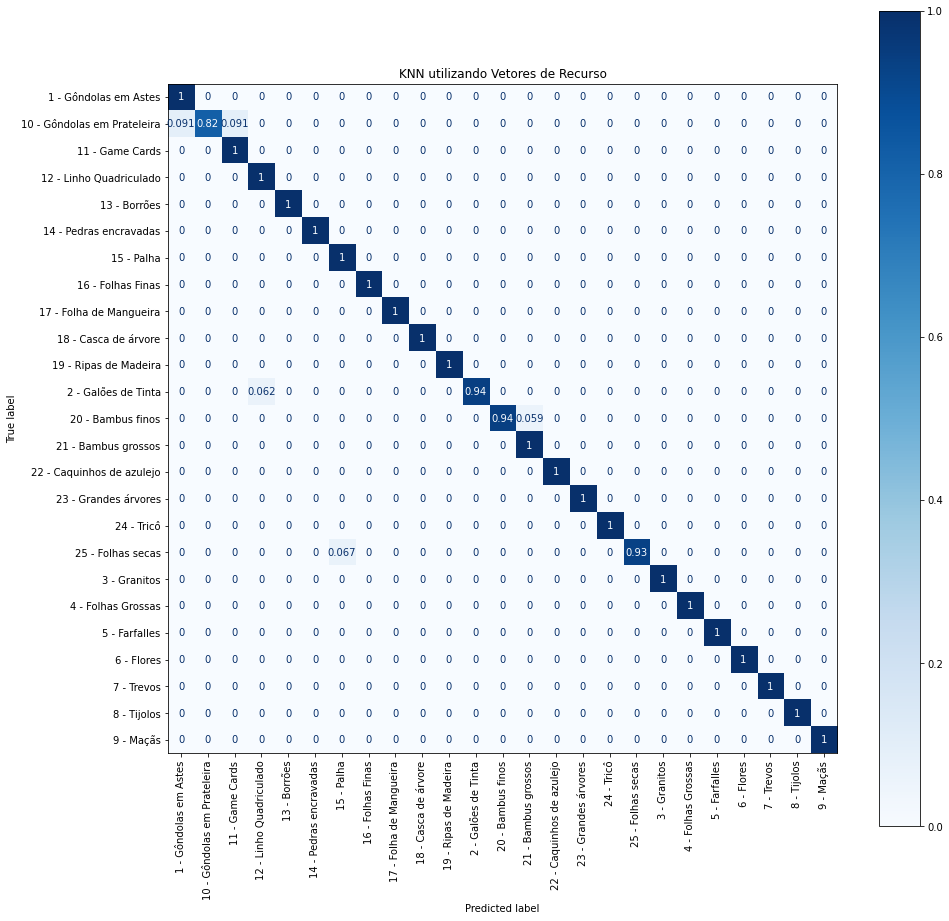

SVC Linear utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.90909091 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.  

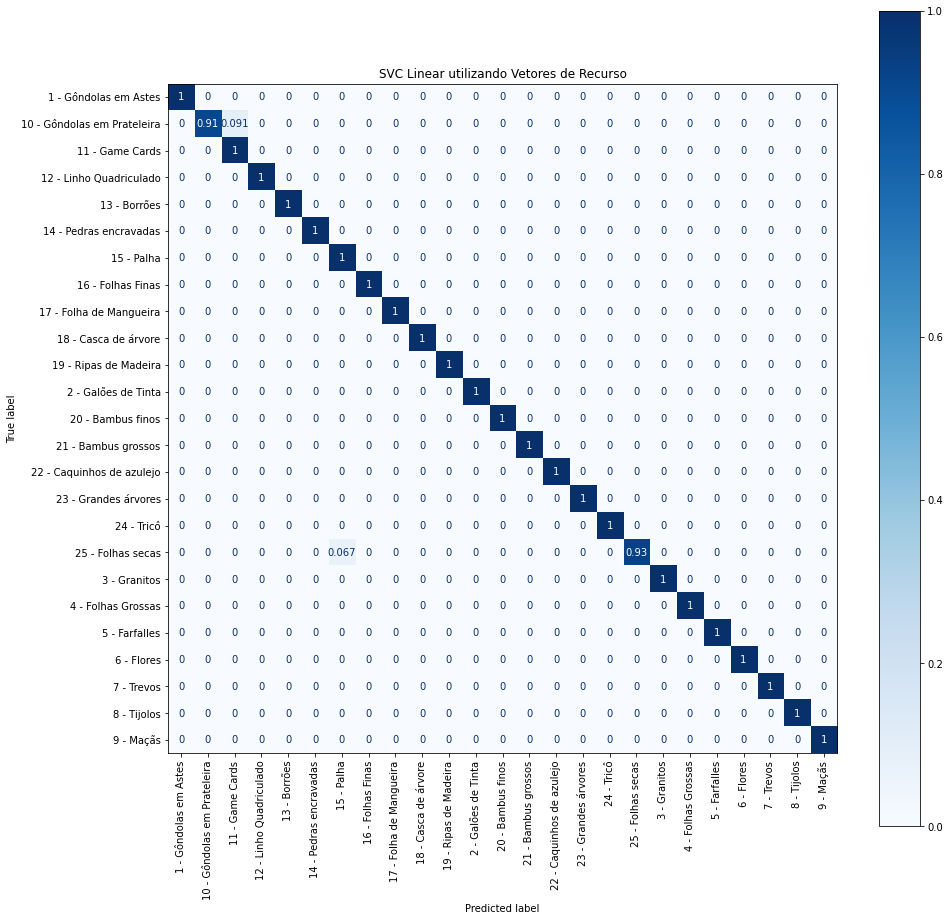

Processo Gaussiano utilizando Vetores de Recurso
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.     

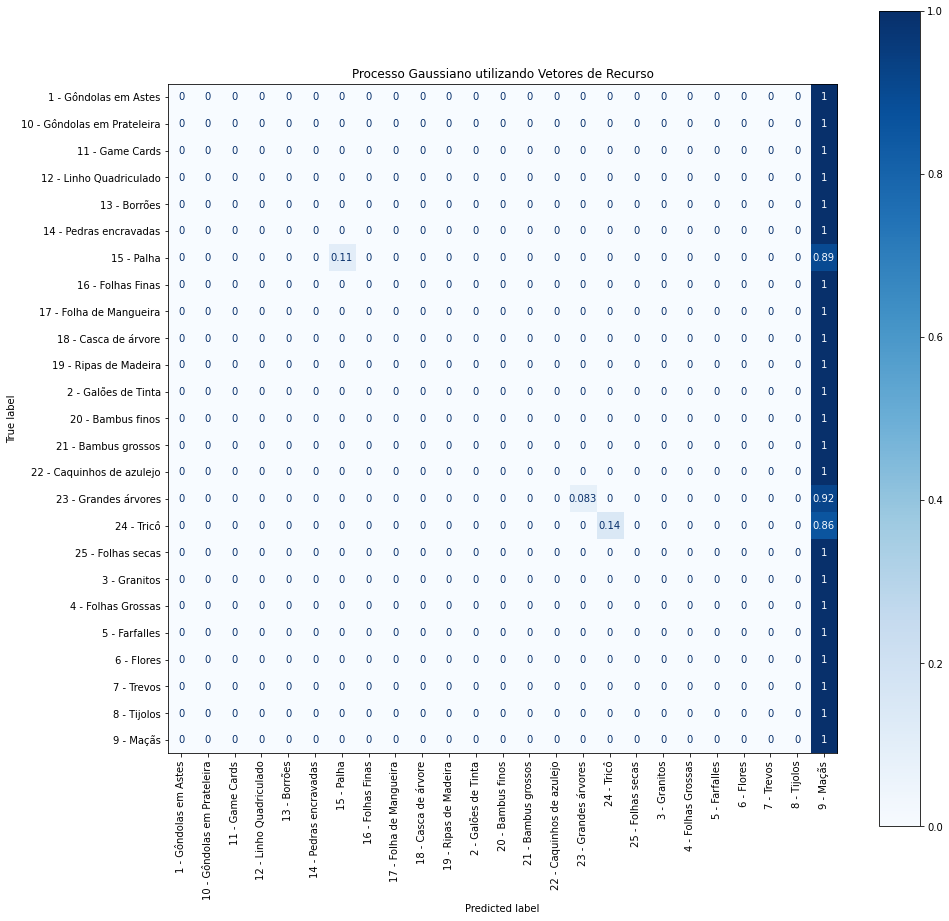

Árvores de Decisão utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.73684211 0.         0.
  0.         0.26315789 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.     

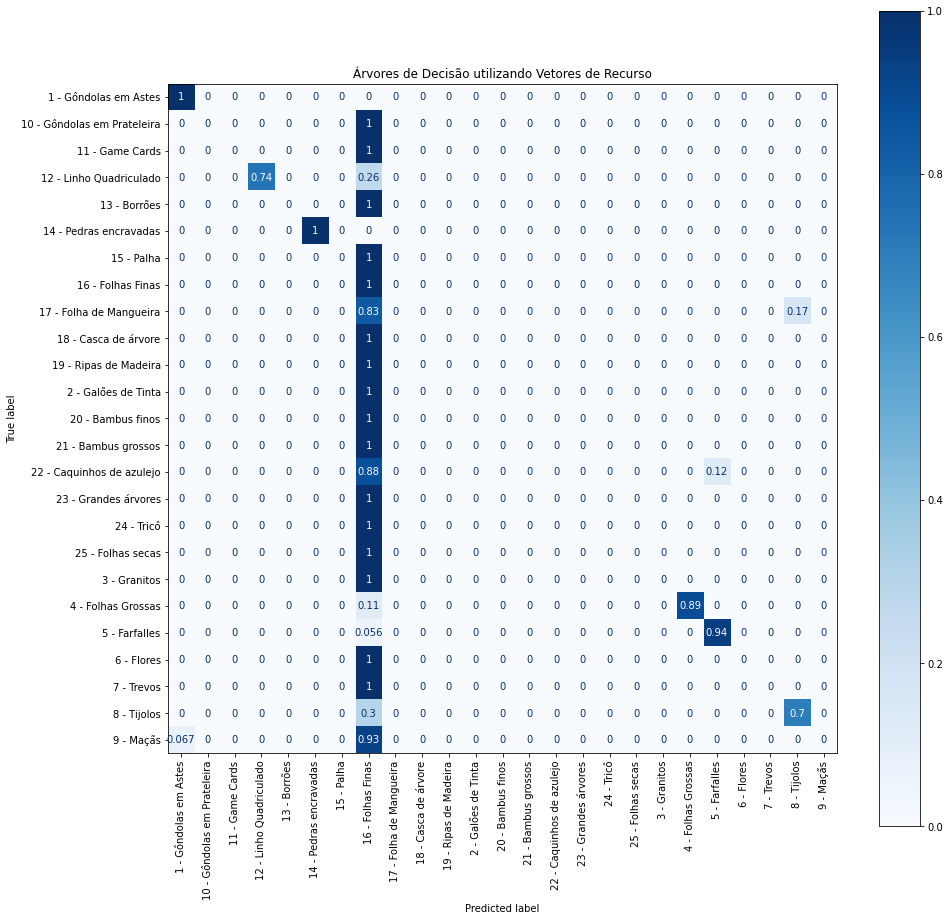

Floresta Aleatória utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.81818182 0.         0.09090909 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.09090909 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.0625     0.         0.9375     0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.     

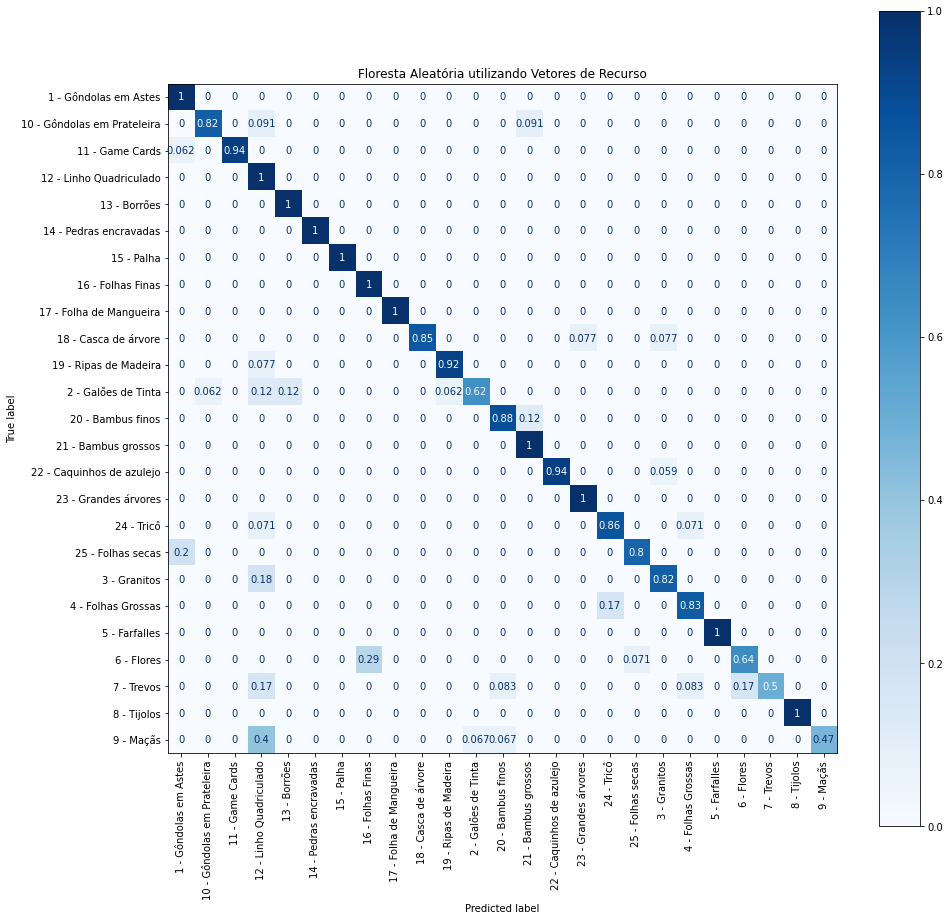

MLP utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.90909091 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         

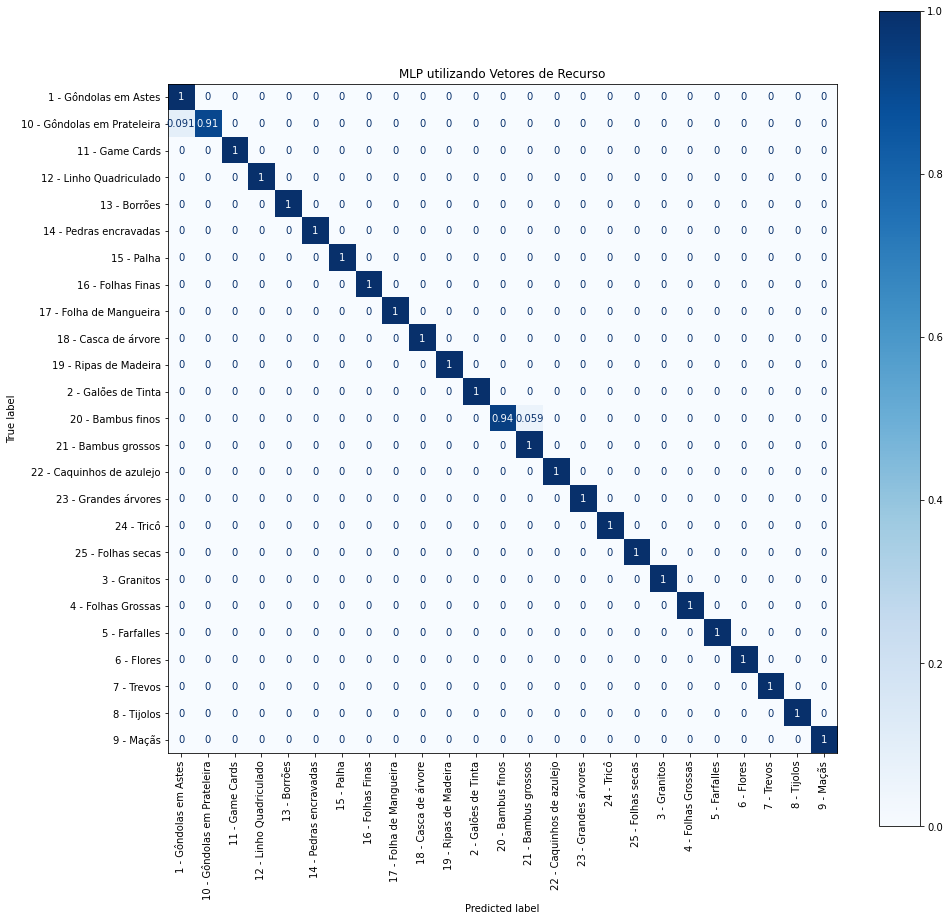

AdaBoost utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.81818182 0.         0.18181818 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

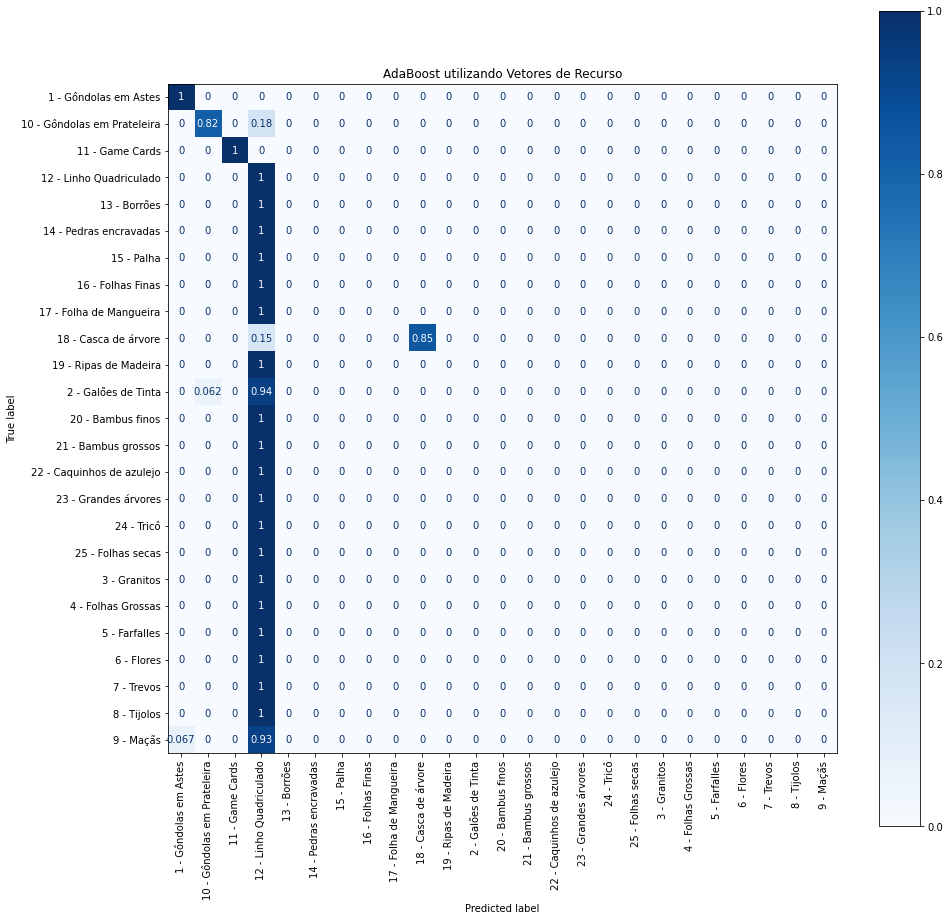

Naive Bayes utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.90909091 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0. 

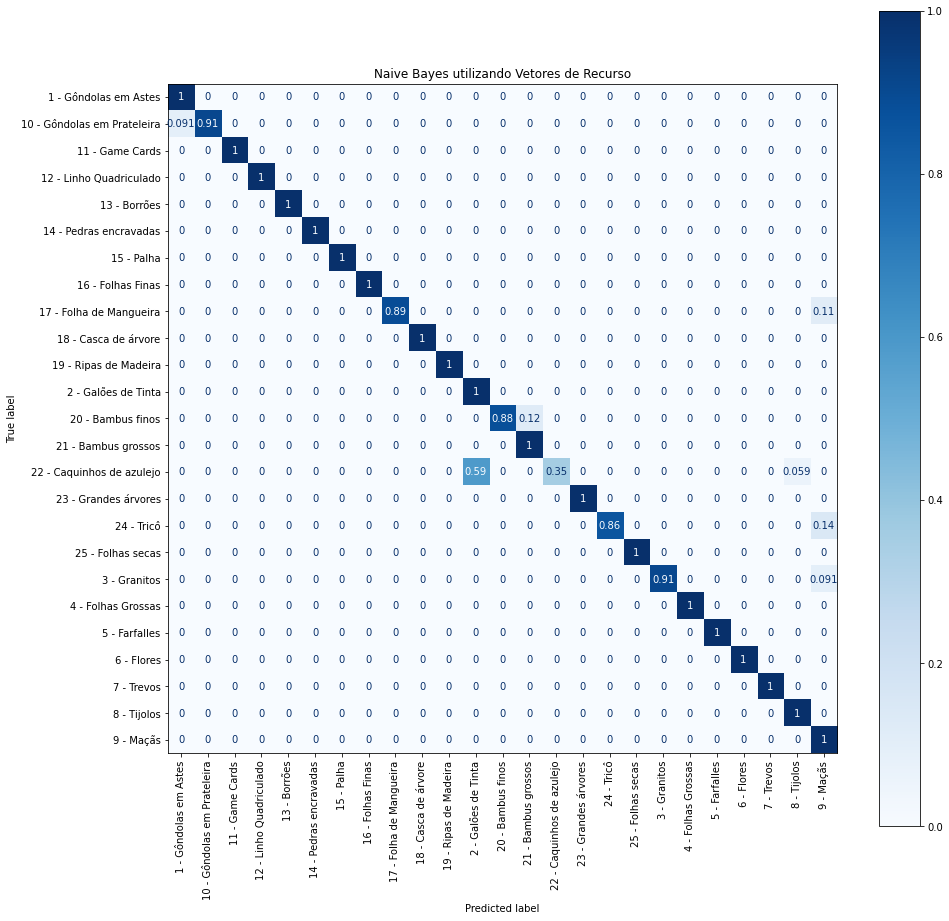

Regressão Logística utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.81818182 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.    

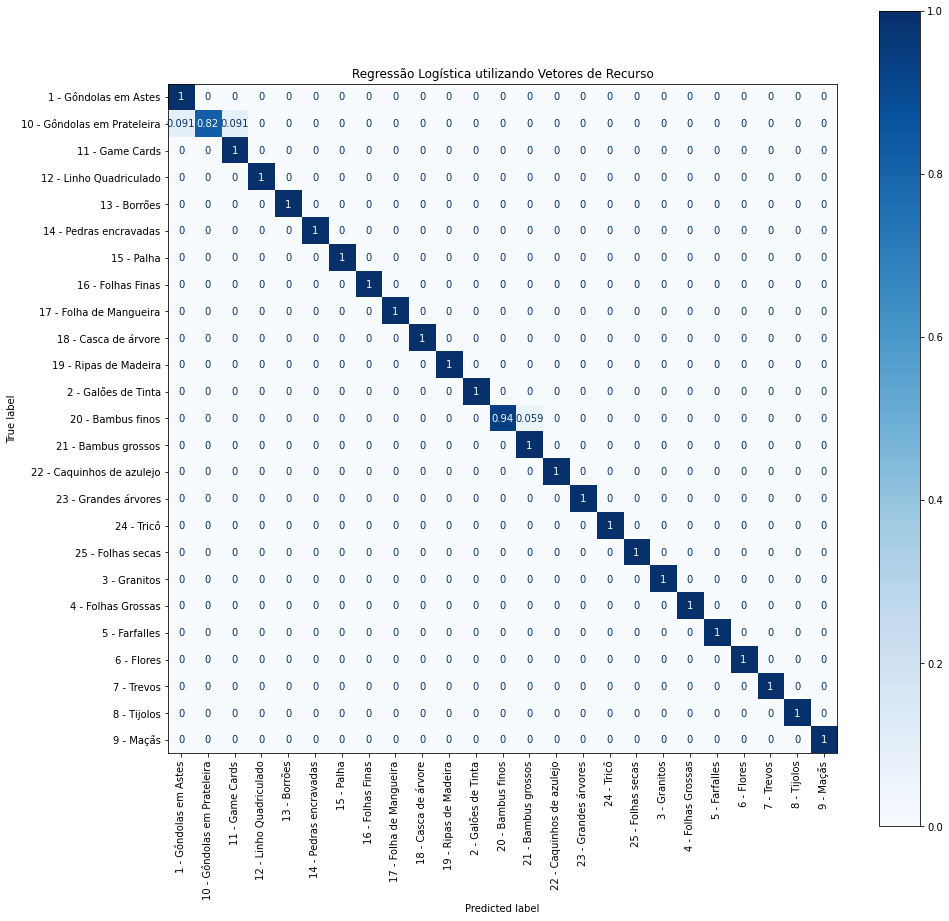

In [94]:
# Matriz de confusão para o classificadores utilizando os vetores de recurso
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
i = 0
for k in names:
    if names[i]=='Regressão Linear':
        i += 1
        continue
    title_options = [(names[i]+" utilizando Vetores de Recurso", 'true')]
    xrt='vertical'
    for title, normalize in title_options:
        disp = plot_confusion_matrix(w_classif[i], xxvd, xxlv,
                                     display_labels=xclasses,
                                     cmap = plt.cm.Blues,
                                     xticks_rotation = xrt,       
                                     normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()
    i += 1

KNN com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.81818182 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

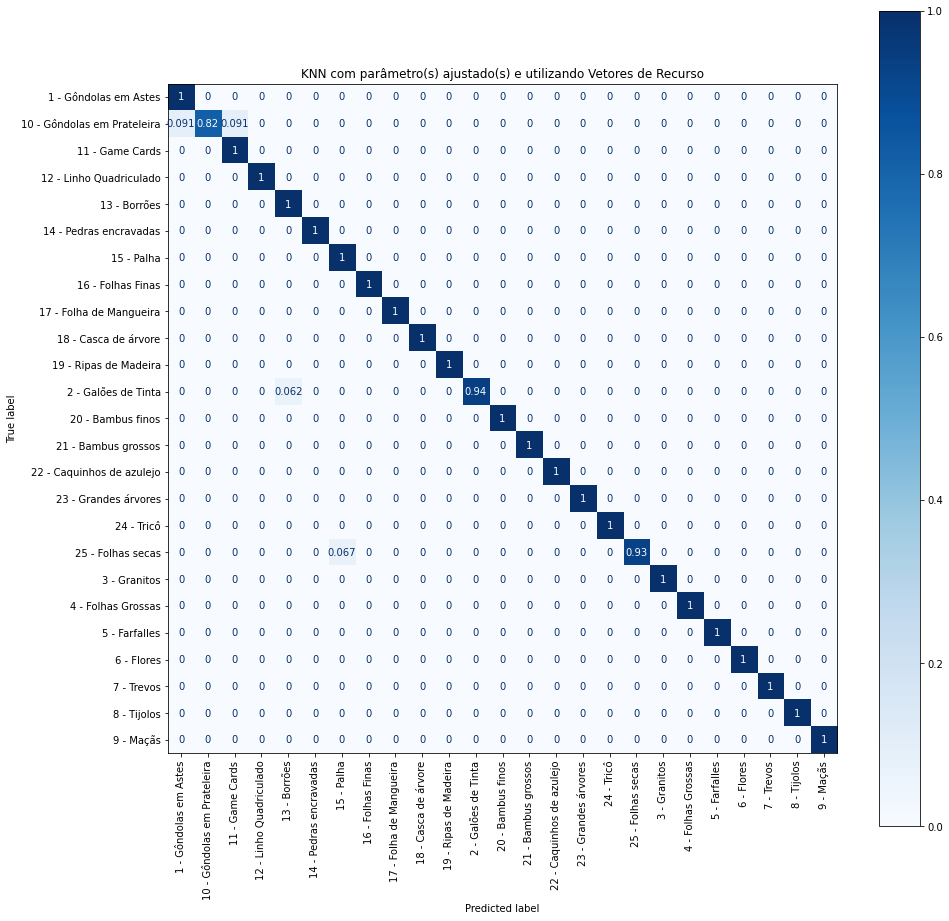

SVC Linear com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.90909091 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

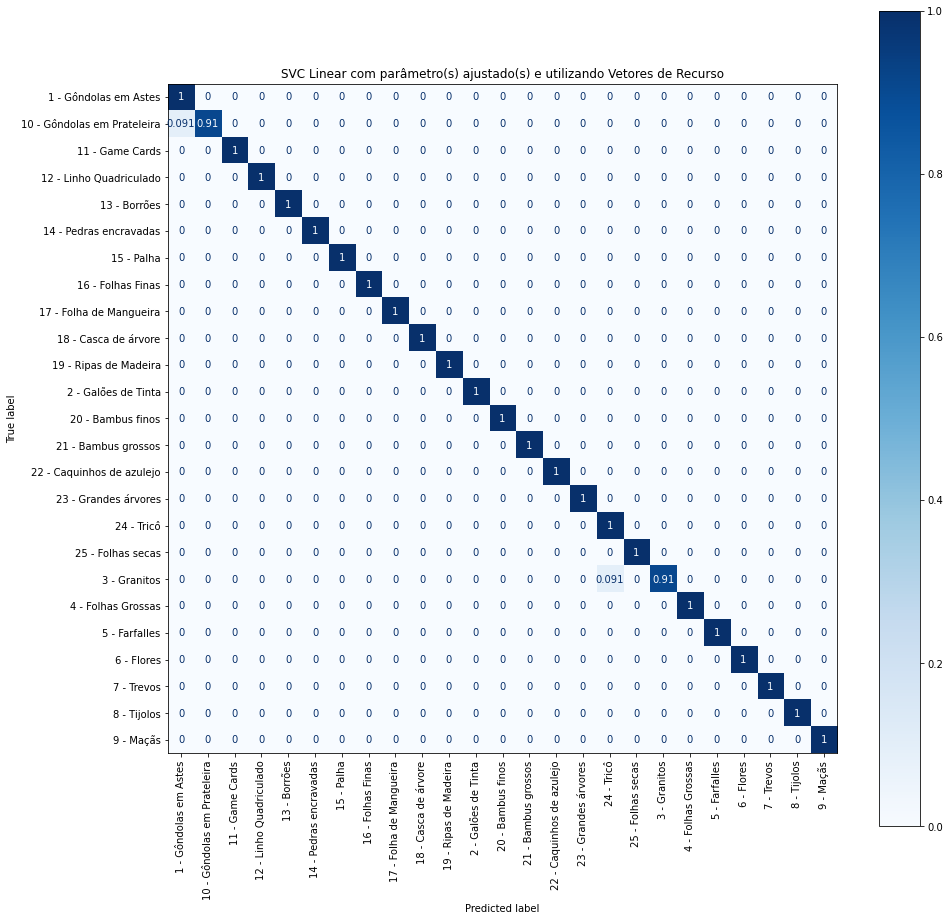

Processo Gaussiano com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0. 

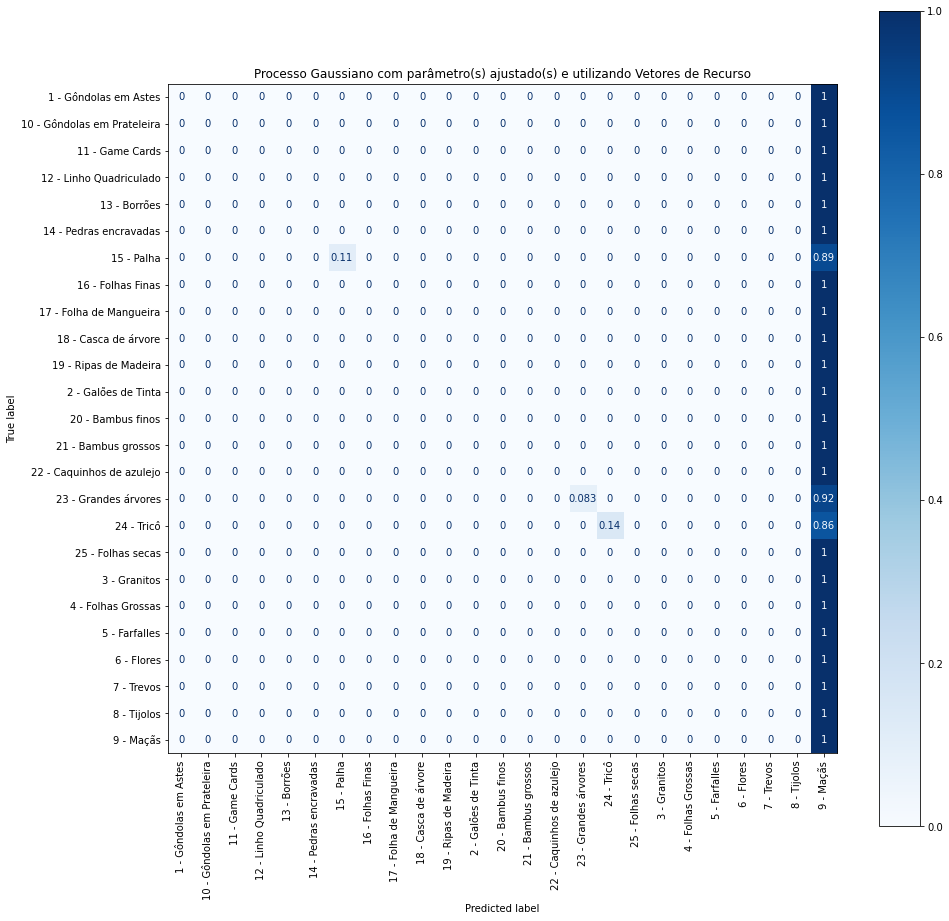

Árvores de Decisão com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.72727273 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.09090909 0.         0.         0.         0.18181818
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.73684211 0.         0.
  0.         0.         0.         0.         0.05263158 0.
  0.         0.05263158 0.    

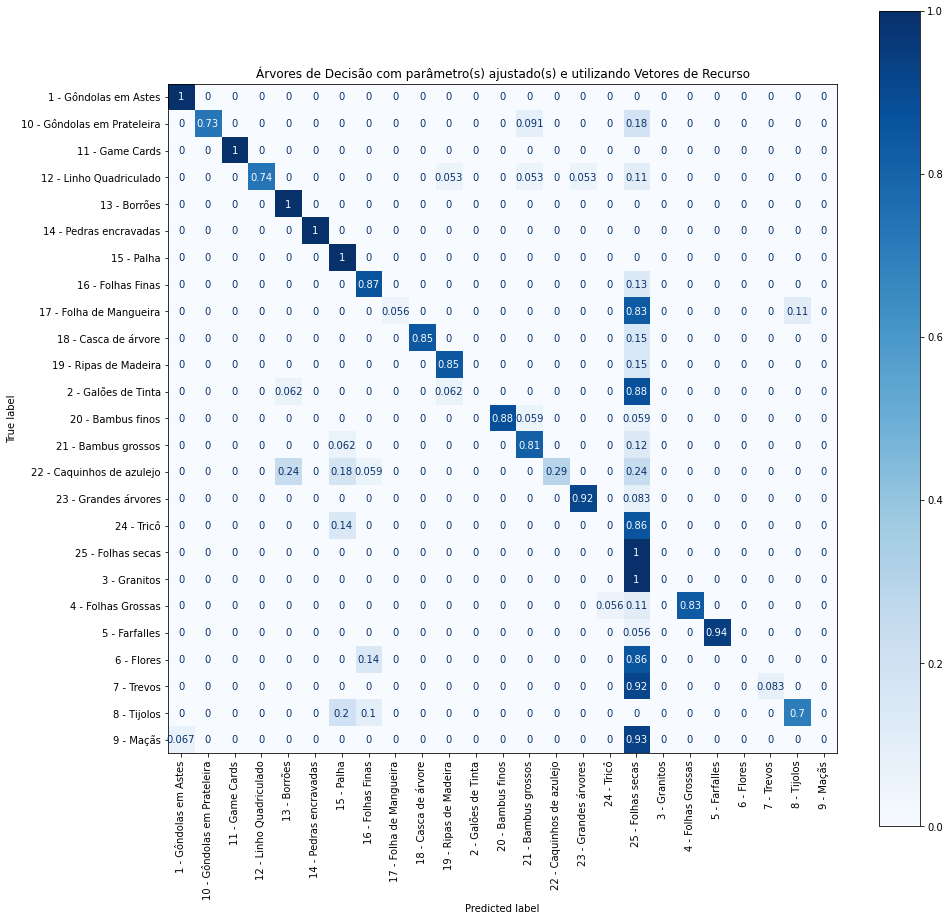

Floresta Aleatória com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.18181818 0.81818182 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0. 

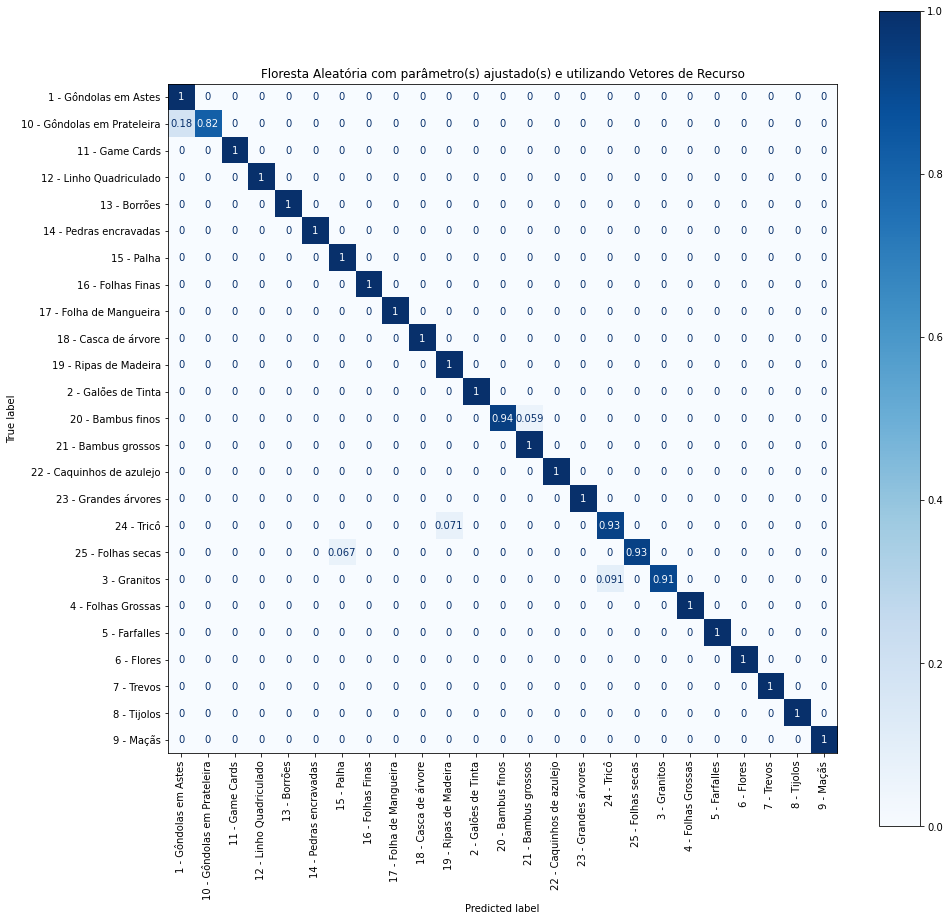

MLP com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.81818182 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.     

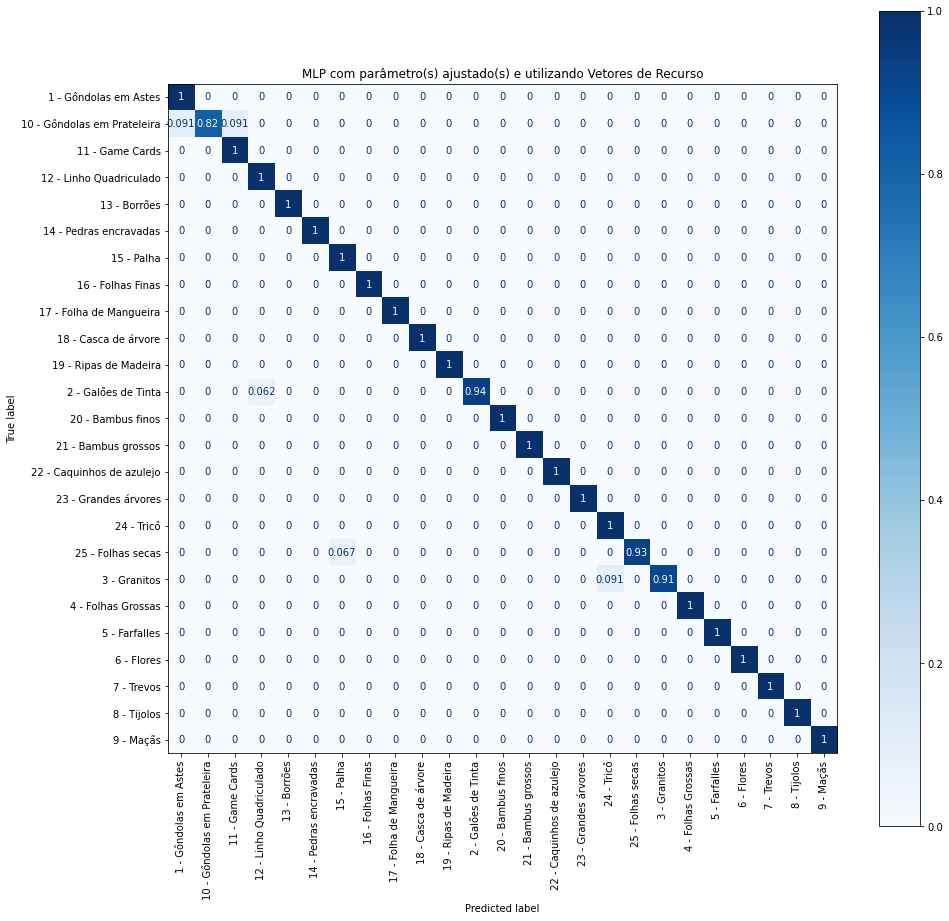

AdaBoost com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.81818182 0.         0.18181818 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.

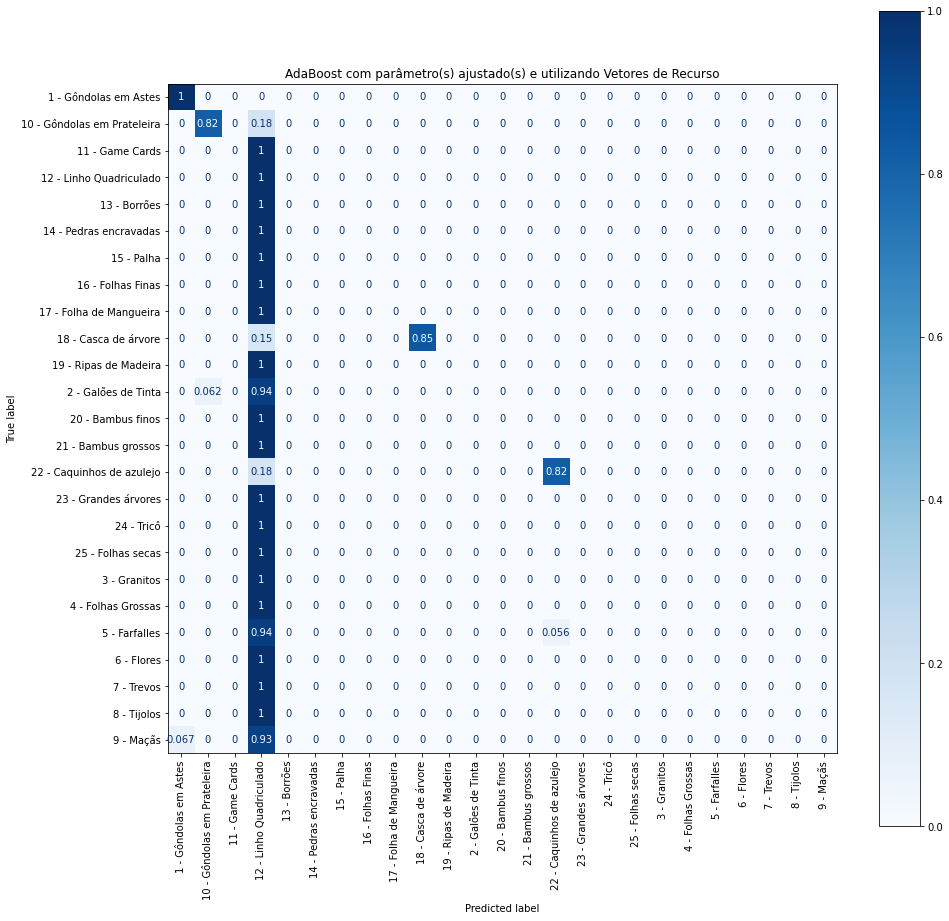

Naive Bayes com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.90909091 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        

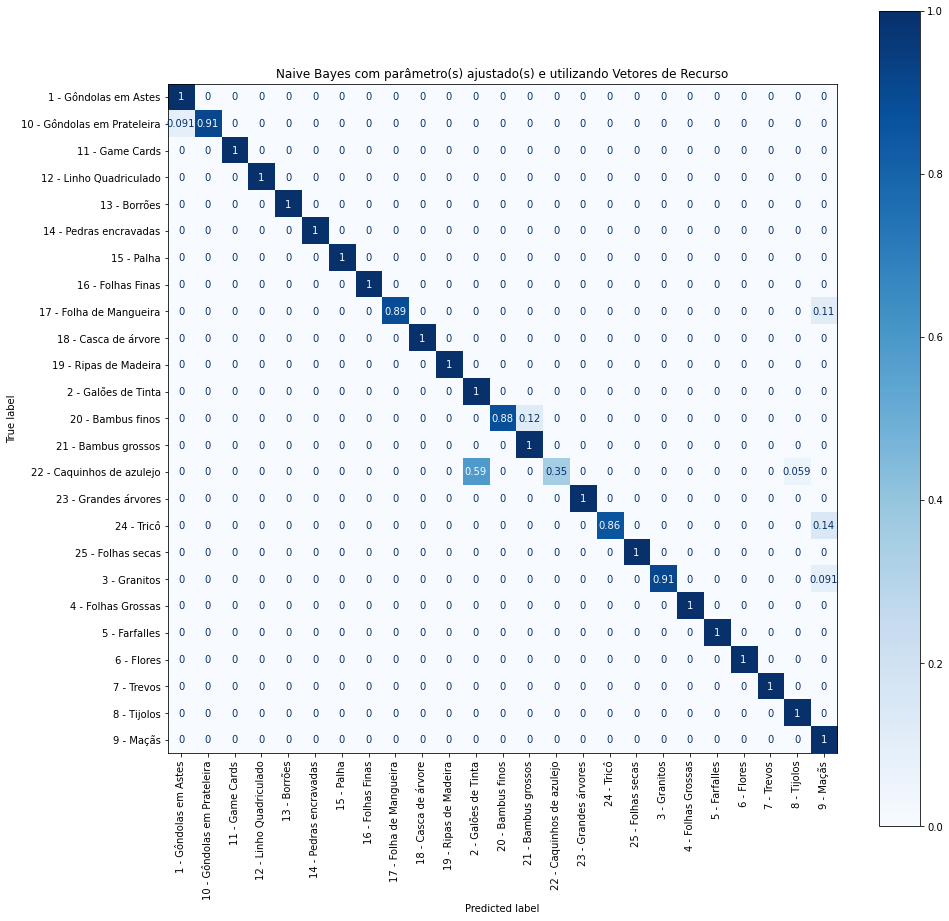

Regressão Logística com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.09090909 0.81818182 0.09090909 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.

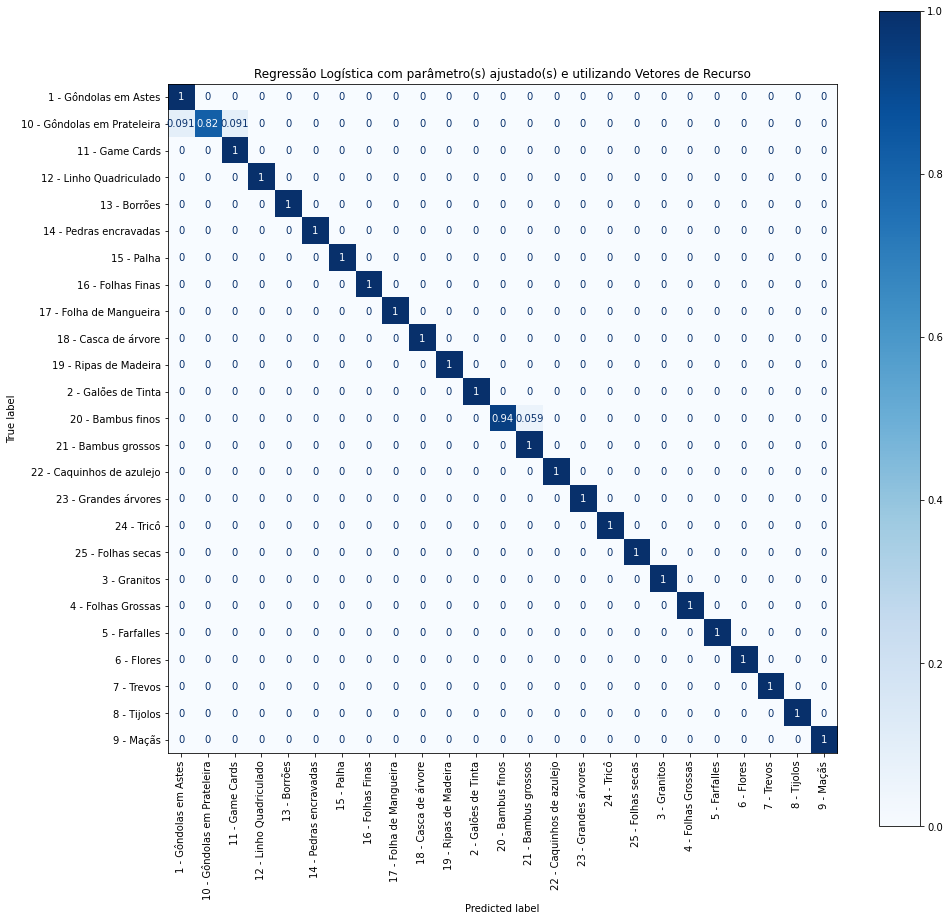

In [95]:
# Matriz de confusão para o classificadores, com parâmetros ajustados e utilizando os vetores de recurso
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
i = 0
'''names = ["0 KNN", 
         "1 SVC Linear", 
         "2 Processo Gaussiano",
         "3 Árvores de Decisão", 
         "4 Floresta Aleatória", 
         "5 MLP", 
         "6 AdaBoost",
         "7 Naive Bayes", 
         "8 Regressão Logística", 
         "9 Regressão Linear"]'''
for k in names:
    if names[i]=='Regressão Linear':
        continue
    title_options = [(names[i]+" com parâmetro(s) ajustado(s) e utilizando Vetores de Recurso", 'true')]
    xrt='vertical'
    if i == 0:
        e_classif = knn_best
    if i == 1:
        e_classif = svc_best
    if i == 2:
        e_classif = gpc_best
    if i == 3:
        e_classif = dtc_best
    if i == 4:
        e_classif = rf_best
    if i == 5:
        e_classif = mlp_best
    if i == 6:
        e_classif = ada_best
    if i == 7:
        e_classif = gnb_best
    if i == 8:
        e_classif = LogR_best
    for title, normalize in title_options:
        disp = plot_confusion_matrix(e_classif, xxvd, xxlv,
                                     display_labels=xclasses,
                                     cmap = plt.cm.Blues,
                                     xticks_rotation = xrt,       
                                     normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()
    i += 1

In [96]:
from google.colab import output
for p in range(10):
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  time.sleep (2)